
Analyzing dataset: 30x1x50_Structural
Loaded thermal data shape: (7617, 24, 32)
Data type: float32
Timestamps shape: (7617,)
Temperature range: nan - nan
Printing window: frames 0-1904
Duration: 419.1 seconds
Crop validation - Activity ratio: 0.00
Temperature ratio: 0.00
Recommendations:
  - Consider expanding crop region - capturing < 70% of thermal activity
  - Crop region may be missing hot spots

Analyzing dataset: 30x1x50_Speed
Loaded thermal data shape: (10224, 24, 32)
Data type: float32
Timestamps shape: (10224,)
Temperature range: nan - nan
Printing window: frames 0-2556
Duration: 381.5 seconds
Crop validation - Activity ratio: 0.00
Temperature ratio: 0.00
Recommendations:
  - Consider expanding crop region - capturing < 70% of thermal activity
  - Crop region may be missing hot spots

Analyzing dataset: 70x1x50_Structural
Loaded thermal data shape: (15402, 24, 32)
Data type: float32
Timestamps shape: (15402,)
Temperature range: nan - nan
Printing window: frames 0-3850
Duratio

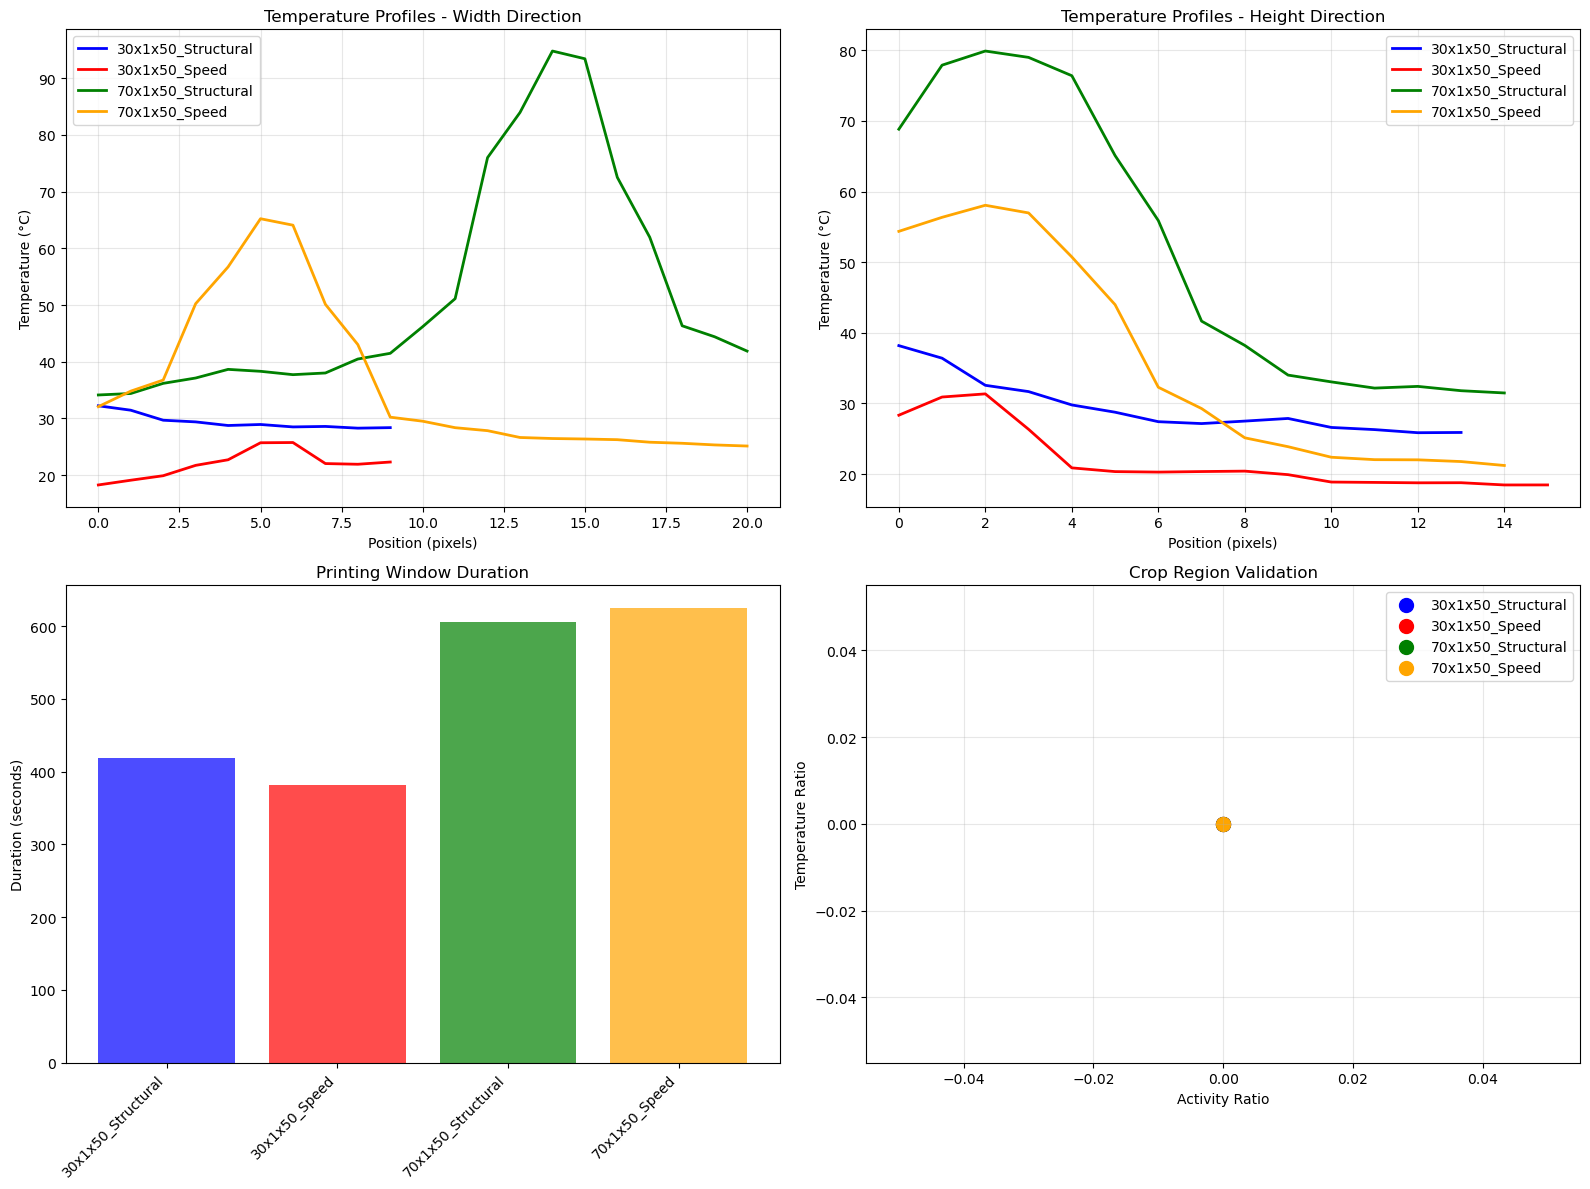

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.signal import find_peaks
import pandas as pd
from datetime import datetime, timedelta

class ThermalProfileAnalyzer:
    def __init__(self, filepath):
        """
        Initialize the thermal profile analyzer with H5 file
        
        Args:
            filepath (str): Path to the H5 file containing thermal data
        """
        self.filepath = filepath
        self.thermal_data = None
        self.timestamps = None
        self.metadata = None
        self.load_data()
    
    def load_data(self):
        """Load thermal data, timestamps, and metadata from H5 file"""
        try:
            with h5py.File(self.filepath, 'r') as f:
                self.thermal_data = f['thermal_images'][:]
                
                # Try to load timestamps from different possible locations
                if 'frame_timestamps' in f.keys():
                    self.timestamps = f['frame_timestamps'][:]
                elif 'metadata' in f.keys() and 'frame_timestamps' in f['metadata'].attrs:
                    self.timestamps = f['metadata'].attrs['frame_timestamps']
                else:
                    # Generate synthetic timestamps based on metadata
                    if 'metadata' in f.keys():
                        self.metadata = dict(f['metadata'].attrs)
                        if 'total_duration_seconds' in self.metadata:
                            duration = self.metadata['total_duration_seconds']
                            n_frames = self.thermal_data.shape[0]
                            self.timestamps = np.linspace(0, duration, n_frames)
                        else:
                            # Fallback: assume uniform spacing
                            self.timestamps = np.arange(self.thermal_data.shape[0])
                    else:
                        self.timestamps = np.arange(self.thermal_data.shape[0])
                
                if 'metadata' in f.keys():
                    self.metadata = dict(f['metadata'].attrs)
                
                print(f"Loaded thermal data shape: {self.thermal_data.shape}")
                print(f"Data type: {self.thermal_data.dtype}")
                print(f"Timestamps shape: {self.timestamps.shape}")
                print(f"Temperature range: {self.thermal_data.min():.2f} - {self.thermal_data.max():.2f}")
                
        except Exception as e:
            print(f"Error loading data: {e}")
            raise
    
    def get_temperature_profiles(self, frame_idx=None, region=None):
        """
        Extract temperature profiles in width and height directions
        
        Args:
            frame_idx (int, optional): Specific frame index. If None, uses mean across all frames
            region (dict, optional): Region to analyze {'x_range': (x1, x2), 'y_range': (y1, y2)}
        
        Returns:
            dict: Contains width and height temperature profiles
        """
        if frame_idx is not None:
            data = self.thermal_data[frame_idx]
        else:
            # Use temporal mean for overall profile
            data = np.mean(self.thermal_data, axis=0)
        
        # Apply region cropping if specified
        if region:
            x1, x2 = region['x_range']
            y1, y2 = region['y_range']
            data = data[y1:y2, x1:x2]
        
        # Calculate profiles
        width_profile = np.mean(data, axis=0)  # Average along height (y-axis)
        height_profile = np.mean(data, axis=1)  # Average along width (x-axis)
        
        return {
            'width_profile': width_profile,
            'height_profile': height_profile,
            'width_positions': np.arange(len(width_profile)),
            'height_positions': np.arange(len(height_profile)),
            'frame_data': data
        }
    
    def detect_printing_window(self, temperature_threshold=None, activity_threshold=0.1):
        """
        Detect the printing time window based on thermal activity
        
        Args:
            temperature_threshold (float, optional): Temperature threshold for activity detection
            activity_threshold (float): Minimum activity level to consider as printing
        
        Returns:
            dict: Start and end frame indices, timestamps, and analysis data
        """
        # Calculate thermal activity metrics
        temporal_mean = np.mean(self.thermal_data, axis=(1, 2))  # Mean temperature per frame
        temporal_std = np.std(self.thermal_data, axis=(1, 2))    # Temperature variation per frame
        temporal_max = np.max(self.thermal_data, axis=(1, 2))    # Max temperature per frame
        
        # Calculate temperature differences between consecutive frames
        temp_diff = np.abs(np.diff(temporal_mean))
        temp_diff = np.concatenate([[0], temp_diff])  # Add zero for first frame
        
        # Smooth the signals to reduce noise
        window_size = min(50, len(temporal_mean) // 10)
        temporal_mean_smooth = ndimage.uniform_filter1d(temporal_mean, size=window_size)
        temp_diff_smooth = ndimage.uniform_filter1d(temp_diff, size=window_size)
        
        # Auto-determine threshold if not provided
        if temperature_threshold is None:
            temperature_threshold = np.mean(temporal_mean) + 0.5 * np.std(temporal_mean)
        
        # Find regions with significant thermal activity
        activity_mask = (temporal_mean_smooth > temperature_threshold) & \
                       (temp_diff_smooth > activity_threshold)
        
        # Find continuous regions of activity
        activity_regions = []
        in_region = False
        start_idx = 0
        
        for i, active in enumerate(activity_mask):
            if active and not in_region:
                start_idx = i
                in_region = True
            elif not active and in_region:
                activity_regions.append((start_idx, i-1))
                in_region = False
        
        # Handle case where activity continues to the end
        if in_region:
            activity_regions.append((start_idx, len(activity_mask)-1))
        
        # Select the longest activity region as the main printing window
        if activity_regions:
            longest_region = max(activity_regions, key=lambda x: x[1] - x[0])
            start_frame, end_frame = longest_region
        else:
            # Fallback: use peak activity period
            peak_idx = np.argmax(temporal_mean_smooth)
            margin = len(temporal_mean) // 4
            start_frame = max(0, peak_idx - margin)
            end_frame = min(len(temporal_mean) - 1, peak_idx + margin)
        
        # Convert frame indices to timestamps
        start_time = self.timestamps[start_frame] if start_frame < len(self.timestamps) else 0
        end_time = self.timestamps[end_frame] if end_frame < len(self.timestamps) else self.timestamps[-1]
        
        return {
            'start_frame': start_frame,
            'end_frame': end_frame,
            'start_time': start_time,
            'end_time': end_time,
            'duration_frames': end_frame - start_frame + 1,
            'duration_seconds': end_time - start_time,
            'temporal_mean': temporal_mean,
            'temporal_std': temporal_std,
            'temporal_max': temporal_max,
            'temp_diff': temp_diff,
            'activity_mask': activity_mask,
            'temperature_threshold': temperature_threshold,
            'all_activity_regions': activity_regions
        }
    
    def plot_temporal_analysis(self, printing_window=None, save_path=None):
        """
        Plot temporal analysis showing thermal activity and detected printing window
        
        Args:
            printing_window (dict, optional): Output from detect_printing_window()
            save_path (str, optional): Path to save the plot
        """
        if printing_window is None:
            printing_window = self.detect_printing_window()
        
        fig, axes = plt.subplots(3, 1, figsize=(15, 12))
        
        time_seconds = (self.timestamps - self.timestamps[0])
        
        # Plot 1: Mean temperature over time
        axes[0].plot(time_seconds, printing_window['temporal_mean'], 'b-', linewidth=1, alpha=0.7)
        axes[0].axhline(y=printing_window['temperature_threshold'], color='r', linestyle='--', 
                       label=f'Threshold: {printing_window["temperature_threshold"]:.2f}°C')
        axes[0].axvspan(time_seconds[printing_window['start_frame']], 
                       time_seconds[printing_window['end_frame']], 
                       alpha=0.3, color='green', label='Detected Printing Window')
        axes[0].set_ylabel('Mean Temperature (°C)')
        axes[0].set_title('Thermal Activity Analysis')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Temperature variation (std) over time
        axes[1].plot(time_seconds, printing_window['temporal_std'], 'orange', linewidth=1)
        axes[1].axvspan(time_seconds[printing_window['start_frame']], 
                       time_seconds[printing_window['end_frame']], 
                       alpha=0.3, color='green')
        axes[1].set_ylabel('Temperature Std (°C)')
        axes[1].set_title('Temperature Variation Over Time')
        axes[1].grid(True, alpha=0.3)
        
        # Plot 3: Temperature change rate
        axes[2].plot(time_seconds, printing_window['temp_diff'], 'purple', linewidth=1)
        axes[2].axvspan(time_seconds[printing_window['start_frame']], 
                       time_seconds[printing_window['end_frame']], 
                       alpha=0.3, color='green')
        axes[2].set_ylabel('Temperature Change Rate (°C/frame)')
        axes[2].set_xlabel('Time (seconds)')
        axes[2].set_title('Temperature Change Rate')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # Print summary
        print(f"\nPrinting Window Detection Summary:")
        print(f"Start frame: {printing_window['start_frame']}")
        print(f"End frame: {printing_window['end_frame']}")
        print(f"Duration: {printing_window['duration_frames']} frames ({printing_window['duration_seconds']:.1f} seconds)")
        print(f"Temperature threshold used: {printing_window['temperature_threshold']:.2f}°C")
    
    def plot_temperature_profiles(self, frame_idx=None, region=None, save_path=None):
        """
        Plot temperature profiles in width and height directions
        
        Args:
            frame_idx (int, optional): Specific frame to analyze
            region (dict, optional): Region to crop for analysis
            save_path (str, optional): Path to save the plot
        """
        profiles = self.get_temperature_profiles(frame_idx, region)
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Plot thermal image
        im = ax1.imshow(profiles['frame_data'], cmap='hot', aspect='auto')
        ax1.set_title(f'Thermal Image (Frame {frame_idx if frame_idx else "Mean"})')
        ax1.set_xlabel('Width (pixels)')
        ax1.set_ylabel('Height (pixels)')
        plt.colorbar(im, ax=ax1, label='Temperature (°C)')
        
        # Plot width profile
        ax2.plot(profiles['width_positions'], profiles['width_profile'], 'b-', linewidth=2)
        ax2.set_xlabel('Position along width (pixels)')
        ax2.set_ylabel('Average Temperature (°C)')
        ax2.set_title('Temperature Profile - Width Direction')
        ax2.grid(True, alpha=0.3)
        
        # Plot height profile
        ax3.plot(profiles['height_positions'], profiles['height_profile'], 'r-', linewidth=2)
        ax3.set_xlabel('Position along height (pixels)')
        ax3.set_ylabel('Average Temperature (°C)')
        ax3.set_title('Temperature Profile - Height Direction')
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        return profiles
    
    def validate_crop_region(self, crop_config, printing_window=None):
        """
        Validate the crop region by analyzing the thermal activity within it
        
        Args:
            crop_config (dict): Crop configuration with 'x_range' and 'y_range'
            printing_window (dict, optional): Output from detect_printing_window()
        
        Returns:
            dict: Validation metrics and recommendations
        """
        if printing_window is None:
            printing_window = self.detect_printing_window()
        
        x1, x2 = crop_config['x_range']
        y1, y2 = crop_config['y_range']
        
        # Extract cropped region during printing window
        start_frame = printing_window['start_frame']
        end_frame = printing_window['end_frame']
        
        cropped_data = self.thermal_data[start_frame:end_frame+1, y1:y2, x1:x2]
        full_data = self.thermal_data[start_frame:end_frame+1, :, :]
        
        # Calculate metrics
        cropped_mean_temp = np.mean(cropped_data)
        full_mean_temp = np.mean(full_data)
        cropped_max_temp = np.max(cropped_data)
        full_max_temp = np.max(full_data)
        cropped_activity = np.std(cropped_data)
        full_activity = np.std(full_data)
        
        # Calculate the percentage of thermal activity captured
        activity_ratio = cropped_activity / full_activity if full_activity > 0 else 0
        temp_ratio = cropped_mean_temp / full_mean_temp if full_mean_temp > 0 else 0
        
        validation_results = {
            'crop_region': crop_config,
            'cropped_mean_temp': cropped_mean_temp,
            'full_mean_temp': full_mean_temp,
            'cropped_max_temp': cropped_max_temp,
            'full_max_temp': full_max_temp,
            'activity_ratio': activity_ratio,
            'temperature_ratio': temp_ratio,
            'region_size': (x2-x1, y2-y1),
            'total_size': (self.thermal_data.shape[2], self.thermal_data.shape[1]),
            'area_ratio': ((x2-x1) * (y2-y1)) / (self.thermal_data.shape[1] * self.thermal_data.shape[2])
        }
        
        # Provide recommendations
        recommendations = []
        if activity_ratio < 0.7:
            recommendations.append("Consider expanding crop region - capturing < 70% of thermal activity")
        if temp_ratio < 0.8:
            recommendations.append("Crop region may be missing hot spots")
        if validation_results['area_ratio'] > 0.8:
            recommendations.append("Crop region is quite large - consider reducing if computational efficiency is important")
        
        validation_results['recommendations'] = recommendations
        
        return validation_results

# Example usage functions
def analyze_all_datasets(crop_configurations, filepaths):
    """
    Analyze all datasets and provide comprehensive summary
    
    Args:
        crop_configurations (dict): Crop configurations for each dataset
        filepaths (dict): File paths for each dataset (optional, can be empty)
    
    Returns:
        dict: Complete analysis results for all datasets
    """
    results = {}
    
    for dataset_name, config in crop_configurations.items():
        print(f"\n{'='*60}")
        print(f"Analyzing dataset: {dataset_name}")
        print('='*60)
        
        try:
            analyzer = ThermalProfileAnalyzer(config['filepath'])
            
            # Detect printing window
            printing_window = analyzer.detect_printing_window()
            
            # Get temperature profiles during printing window (use frames from detected window)
            start_frame = printing_window['start_frame']
            end_frame = printing_window['end_frame']
            mid_frame = (start_frame + end_frame) // 2
            
            profiles = analyzer.get_temperature_profiles(
                frame_idx=mid_frame,  # Use middle frame of printing window
                region=config
            )
            
            # Validate crop region
            validation = analyzer.validate_crop_region(config, printing_window)
            
            results[dataset_name] = {
                'analyzer': analyzer,
                'printing_window': printing_window,
                'profiles': profiles,
                'validation': validation
            }
            
            # Print summary
            print(f"Printing window: frames {printing_window['start_frame']}-{printing_window['end_frame']}")
            print(f"Duration: {printing_window['duration_seconds']:.1f} seconds")
            print(f"Crop validation - Activity ratio: {validation['activity_ratio']:.2f}")
            print(f"Temperature ratio: {validation['temperature_ratio']:.2f}")
            if validation['recommendations']:
                print("Recommendations:")
                for rec in validation['recommendations']:
                    print(f"  - {rec}")
            else:
                print("Crop region looks good!")
                    
        except Exception as e:
            print(f"Error analyzing {dataset_name}: {e}")
            results[dataset_name] = {'error': str(e)}
    
    return results

def plot_comparison_summary(results):
    """
    Create a comparison plot of all datasets
    
    Args:
        results (dict): Results from analyze_all_datasets()
    """
    # Filter out datasets with errors
    valid_results = {name: data for name, data in results.items() if 'error' not in data}
    
    if not valid_results:
        print("No valid results to plot!")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    colors = ['blue', 'red', 'green', 'orange']
    dataset_names = list(valid_results.keys())
    
    for i, (dataset_name, data) in enumerate(valid_results.items()):
        profiles = data['profiles']
        
        # Plot width profiles
        axes[0].plot(profiles['width_positions'], profiles['width_profile'], 
                    color=colors[i % len(colors)], label=dataset_name, linewidth=2)
        
        # Plot height profiles  
        axes[1].plot(profiles['height_positions'], profiles['height_profile'], 
                    color=colors[i % len(colors)], label=dataset_name, linewidth=2)
        
        # Plot printing window durations
        printing_window = data['printing_window']
        axes[2].bar(i, printing_window['duration_seconds'], 
                   color=colors[i % len(colors)], alpha=0.7)
        
        # Plot validation metrics
        validation = data['validation']
        axes[3].scatter(validation['activity_ratio'], validation['temperature_ratio'], 
                       color=colors[i % len(colors)], s=100, label=dataset_name)
    
    axes[0].set_title('Temperature Profiles - Width Direction')
    axes[0].set_xlabel('Position (pixels)')
    axes[0].set_ylabel('Temperature (°C)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Temperature Profiles - Height Direction')
    axes[1].set_xlabel('Position (pixels)')
    axes[1].set_ylabel('Temperature (°C)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].set_title('Printing Window Duration')
    axes[2].set_ylabel('Duration (seconds)')
    axes[2].set_xticks(range(len(dataset_names)))
    axes[2].set_xticklabels(dataset_names, rotation=45, ha='right')
    
    axes[3].set_title('Crop Region Validation')
    axes[3].set_xlabel('Activity Ratio')
    axes[3].set_ylabel('Temperature Ratio')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Main execution example
if __name__ == "__main__":
    # Define your configurations (replace with your actual data)
    crop_configurations = {
        "30x1x50_Structural": {
            'filepath': r"C:\Users\hakim\Documents\cpe_dt\dataset\real\30x1x50_Structural_thermal_capture_20250721_195758.h5",
            'x_range': (10, 20),
            'y_range': (10, 25)
        },
        "30x1x50_Speed": {
            'filepath': r"C:\Users\hakim\Documents\cpe_dt\dataset\real\30x1x50_Speed_thermal_capture_20250721_214207.h5",
            'x_range': (9, 19),
            'y_range': (4, 19)
        },
        "70x1x50_Structural": {
            'filepath': r"C:\Users\hakim\Documents\cpe_dt\dataset\real\70x1x50_Structural_thermal_capture_20250721_202100.h5",
            'x_range': (8, 29),
            'y_range': (5, 20)
        },
        "70x1x50_Speed": {
            'filepath': r"C:\Users\hakim\Documents\cpe_dt\dataset\real\70x1x50_Speed_thermal_capture_20250721_220957.h5",
            'x_range': (5, 26),
            'y_range': (6, 21)
        }
    }
    
    # Analyze all datasets
    results = analyze_all_datasets(crop_configurations, {})
    
    # Create comparison plots
    plot_comparison_summary(results)
    
    # Individual analysis example
    # analyzer = ThermalProfileAnalyzer(crop_configurations["30x1x50_Structural"]['filepath'])
    # analyzer.plot_temporal_analysis()
    # analyzer.plot_temperature_profiles(region=crop_configurations["30x1x50_Structural"])

# crop with a user defined- region - produce pixel_data


Processing: 30x1x50_Structural
Original shape: (7617, 24, 32)
Cropping region - X: 10:20, Y: 10:25
Cropped shape: (7617, 14, 10)
Saved H5 file: thermal_cropped_output\30x1x50_Structural\30x1x50_Structural_thermal_capture_20250721_195758_cropped.h5
Saved CSV file: thermal_cropped_output\30x1x50_Structural\30x1x50_Structural_thermal_capture_20250721_195758_pixel_data.csv
Saved metadata JSON: thermal_cropped_output\30x1x50_Structural\30x1x50_Structural_thermal_capture_20250721_195758_metadata.json


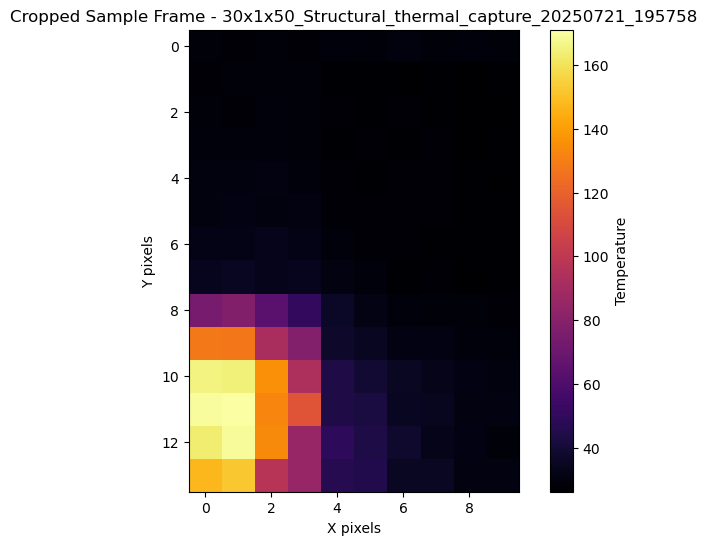


Processing: 30x1x50_Speed
Original shape: (10224, 24, 32)
Cropping region - X: 9:19, Y: 4:19
Cropped shape: (10224, 15, 10)
Saved H5 file: thermal_cropped_output\30x1x50_Speed\30x1x50_Speed_thermal_capture_20250721_214207_cropped.h5
Saved CSV file: thermal_cropped_output\30x1x50_Speed\30x1x50_Speed_thermal_capture_20250721_214207_pixel_data.csv
Saved metadata JSON: thermal_cropped_output\30x1x50_Speed\30x1x50_Speed_thermal_capture_20250721_214207_metadata.json


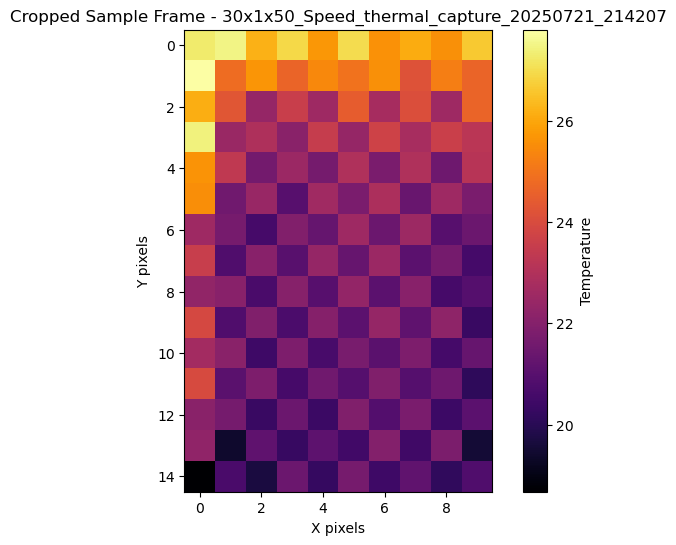


Processing: 70x1x50_Structural
Original shape: (15402, 24, 32)
Cropping region - X: 8:29, Y: 5:20
Cropped shape: (15402, 15, 21)
Saved H5 file: thermal_cropped_output\70x1x50_Structural\70x1x50_Structural_thermal_capture_20250721_202100_cropped.h5
Saved CSV file: thermal_cropped_output\70x1x50_Structural\70x1x50_Structural_thermal_capture_20250721_202100_pixel_data.csv
Saved metadata JSON: thermal_cropped_output\70x1x50_Structural\70x1x50_Structural_thermal_capture_20250721_202100_metadata.json


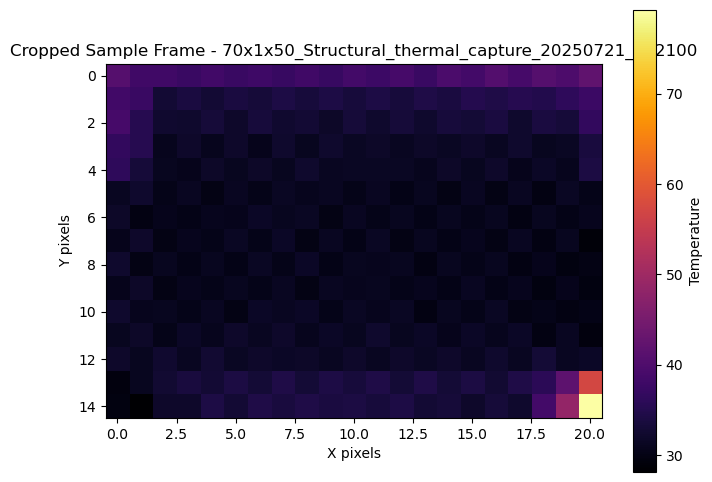


Processing: 70x1x50_Speed
Original shape: (16711, 24, 32)
Cropping region - X: 5:26, Y: 6:21
Cropped shape: (16711, 15, 21)
Saved H5 file: thermal_cropped_output\70x1x50_Speed\70x1x50_Speed_thermal_capture_20250721_220957_cropped.h5
Saved CSV file: thermal_cropped_output\70x1x50_Speed\70x1x50_Speed_thermal_capture_20250721_220957_pixel_data.csv
Saved metadata JSON: thermal_cropped_output\70x1x50_Speed\70x1x50_Speed_thermal_capture_20250721_220957_metadata.json


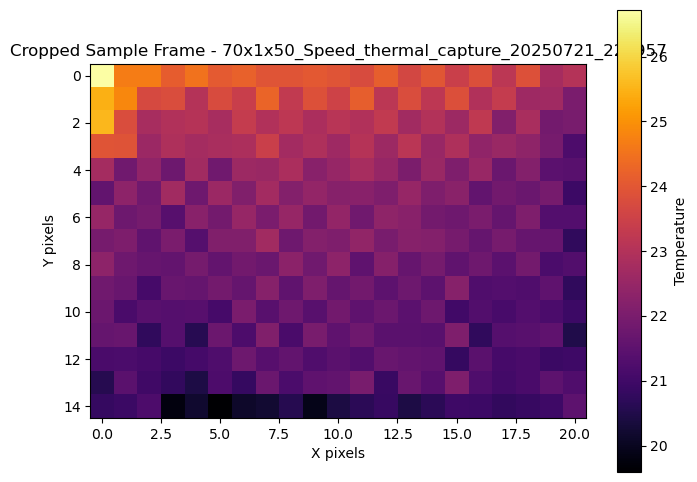


PROCESSING SUMMARY
30x1x50_Structural: ✅ SUCCESS
  Output shape: (7617, 14, 10)
  Output directory: thermal_cropped_output\30x1x50_Structural
30x1x50_Speed: ✅ SUCCESS
  Output shape: (10224, 15, 10)
  Output directory: thermal_cropped_output\30x1x50_Speed
70x1x50_Structural: ✅ SUCCESS
  Output shape: (15402, 15, 21)
  Output directory: thermal_cropped_output\70x1x50_Structural
70x1x50_Speed: ✅ SUCCESS
  Output shape: (16711, 15, 21)
  Output directory: thermal_cropped_output\70x1x50_Speed

Summary saved to: thermal_cropped_output\processing_summary.json


In [4]:
import h5py
import numpy as np
import pandas as pd
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt

def crop_thermal_data(filepath, crop_config, output_dir="cropped_output"):
    """
    Crop thermal data according to specified regions and save in multiple formats.
    
    Args:
        filepath (str): Path to the H5 file
        crop_config (dict): Dictionary containing x_range and y_range for cropping
        output_dir (str): Directory to save output files
    """
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract filename without extension for naming outputs
    filename_base = os.path.splitext(os.path.basename(filepath))[0]
    
    with h5py.File(filepath, 'r') as f:
        # Load thermal images and metadata
        thermal_images = f['thermal_images'][:]
        
        # Try to load timestamps if available
        timestamps = None
        if 'timestamps' in f:
            timestamps = f['timestamps'][:]
        
        # Get crop ranges
        x_start, x_end = crop_config['x_range']
        y_start, y_end = crop_config['y_range']
        
        print(f"Original shape: {thermal_images.shape}")
        print(f"Cropping region - X: {x_start}:{x_end}, Y: {y_start}:{y_end}")
        
        # Crop the thermal images
        cropped_images = thermal_images[:, y_start:y_end, x_start:x_end]
        print(f"Cropped shape: {cropped_images.shape}")
        
        # Save cropped data as H5 file
        h5_output_path = os.path.join(output_dir, f"{filename_base}_cropped.h5")
        with h5py.File(h5_output_path, 'w') as out_f:
            out_f.create_dataset('thermal_images', data=cropped_images)
            if timestamps is not None:
                out_f.create_dataset('timestamps', data=timestamps)
            
            # Add metadata as attributes
            out_f.attrs['original_shape'] = thermal_images.shape
            out_f.attrs['cropped_shape'] = cropped_images.shape
            out_f.attrs['crop_region_x'] = crop_config['x_range']
            out_f.attrs['crop_region_y'] = crop_config['y_range']
            out_f.attrs['source_file'] = filepath
            out_f.attrs['processing_date'] = datetime.now().isoformat()
        
        print(f"Saved H5 file: {h5_output_path}")
        
        # Create CSV with pixel data
        csv_data = []
        num_frames, height, width = cropped_images.shape
        
        for frame_idx in range(num_frames):
            frame_data = cropped_images[frame_idx]
            timestamp = timestamps[frame_idx] if timestamps is not None else frame_idx
            
            for y in range(height):
                for x in range(width):
                    temperature = frame_data[y, x]
                    csv_data.append({
                        'frame': frame_idx,
                        'timestamp': timestamp,
                        'x': x,
                        'y': y,
                        'original_x': x + x_start,
                        'original_y': y + y_start,
                        'temperature': temperature
                    })
        
        # Save CSV file
        csv_output_path = os.path.join(output_dir, f"{filename_base}_pixel_data.csv")
        df = pd.DataFrame(csv_data)
        df.to_csv(csv_output_path, index=False)
        print(f"Saved CSV file: {csv_output_path}")
        
        # Create metadata JSON
        metadata = {
            'source_file': filepath,
            'filename_base': filename_base,
            'processing_date': datetime.now().isoformat(),
            'original_dimensions': {
                'frames': int(thermal_images.shape[0]),
                'height': int(thermal_images.shape[1]),
                'width': int(thermal_images.shape[2])
            },
            'cropped_dimensions': {
                'frames': int(cropped_images.shape[0]),
                'height': int(cropped_images.shape[1]),
                'width': int(cropped_images.shape[2])
            },
            'crop_region': {
                'x_range': crop_config['x_range'],
                'y_range': crop_config['y_range']
            },
            'temperature_statistics': {
                'min': float(np.min(cropped_images)),
                'max': float(np.max(cropped_images)),
                'mean': float(np.mean(cropped_images)),
                'std': float(np.std(cropped_images))
            },
            'total_pixels_per_frame': int(cropped_images.shape[1] * cropped_images.shape[2]),
            'total_data_points': int(cropped_images.size)
        }
        
        # Save metadata JSON
        json_output_path = os.path.join(output_dir, f"{filename_base}_metadata.json")
        with open(json_output_path, 'w') as json_file:
            json.dump(metadata, json_file, indent=2)
        print(f"Saved metadata JSON: {json_output_path}")
        
        # Display a sample cropped frame
        plt.figure(figsize=(8, 6))
        sample_frame = cropped_images[-150] if cropped_images.shape[0] > 150 else cropped_images[-1]
        plt.imshow(sample_frame, cmap='inferno')
        plt.title(f'Cropped Sample Frame - {filename_base}')
        plt.xlabel('X pixels')
        plt.ylabel('Y pixels')
        plt.colorbar(label='Temperature')
        
        # Save the plot
        plot_output_path = os.path.join(output_dir, f"{filename_base}_sample_frame.png")
        plt.savefig(plot_output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return cropped_images, metadata

# Configuration for each dataset
crop_configurations = {
    "30x1x50_Structural": {
        'filepath': r"C:\Users\hakim\Documents\cpe_dt\dataset\real\30x1x50_Structural_thermal_capture_20250721_195758.h5",
        'x_range': (10, 20),
        'y_range': (10, 25)
    },
    "30x1x50_Speed": {
        'filepath': r"C:\Users\hakim\Documents\cpe_dt\dataset\real\30x1x50_Speed_thermal_capture_20250721_214207.h5",
        'x_range': (9, 19),
        'y_range': (4, 19)
    },
    "70x1x50_Structural": {
        'filepath': r"C:\Users\hakim\Documents\cpe_dt\dataset\real\70x1x50_Structural_thermal_capture_20250721_202100.h5",
        'x_range': (8, 29),
        'y_range': (5, 20)
    },
    "70x1x50_Speed": {
        'filepath': r"C:\Users\hakim\Documents\cpe_dt\dataset\real\70x1x50_Speed_thermal_capture_20250721_220957.h5",
        'x_range': (5, 26),
        'y_range': (6, 21)
    }
}
    
# Process all datasets
def process_all_datasets(output_base_dir="thermal_cropped_output"):
    """Process all datasets with their respective crop configurations."""
    
    results = {}
    
    for dataset_name, config in crop_configurations.items():
        print(f"\n{'='*50}")
        print(f"Processing: {dataset_name}")
        print(f"{'='*50}")
        
        # Create specific output directory for this dataset
        dataset_output_dir = os.path.join(output_base_dir, dataset_name)
        
        try:
            cropped_data, metadata = crop_thermal_data(
                filepath=config['filepath'],
                crop_config={'x_range': config['x_range'], 'y_range': config['y_range']},
                output_dir=dataset_output_dir
            )
            
            results[dataset_name] = {
                'success': True,
                'cropped_shape': cropped_data.shape,
                'metadata': metadata,
                'output_dir': dataset_output_dir
            }
            
        except Exception as e:
            print(f"Error processing {dataset_name}: {str(e)}")
            results[dataset_name] = {
                'success': False,
                'error': str(e)
            }
    
    # Save summary results
    summary_path = os.path.join(output_base_dir, "processing_summary.json")
    os.makedirs(output_base_dir, exist_ok=True)
    with open(summary_path, 'w') as f:
        json.dump(results, f, indent=2, default=str)
    
    print(f"\n{'='*50}")
    print("PROCESSING SUMMARY")
    print(f"{'='*50}")
    for dataset_name, result in results.items():
        status = "✅ SUCCESS" if result['success'] else "❌ FAILED"
        print(f"{dataset_name}: {status}")
        if result['success']:
            print(f"  Output shape: {result['cropped_shape']}")
            print(f"  Output directory: {result['output_dir']}")
    
    print(f"\nSummary saved to: {summary_path}")
    return results

# Run the processing
if __name__ == "__main__":
    results = process_all_datasets()

# creating heatmaap from pixel data

Loaded data: 1066380 rows
Dimensions: 7617 frames × 14×10 pixels
Temperature range: -306065920000000005627575581828802674688.00 - 327333389999999988116892644627120652288.00
Generating comprehensive thermal analysis report...
Output directory: thermal_analysis_20250723_222845
1. Creating frame heatmaps...


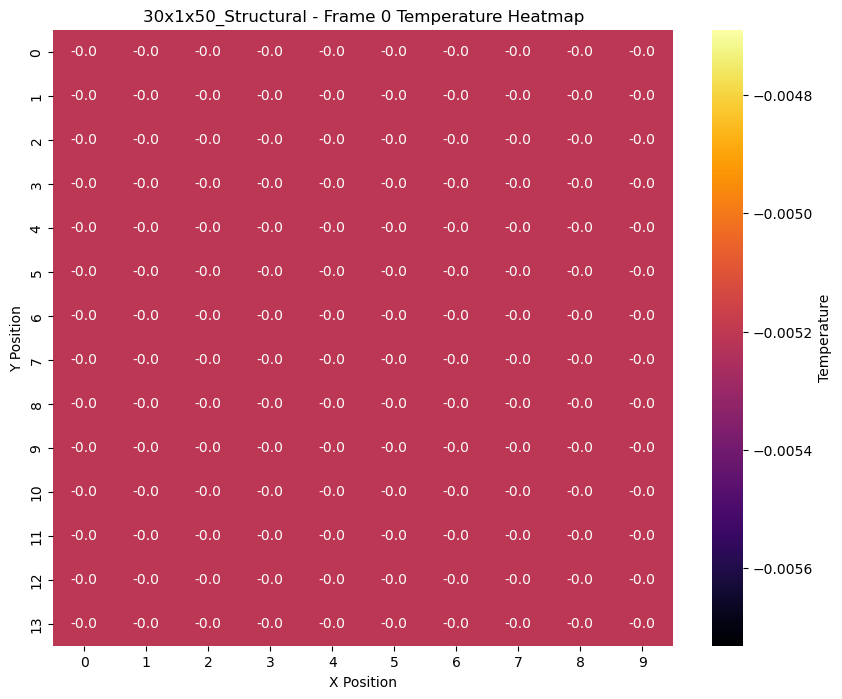

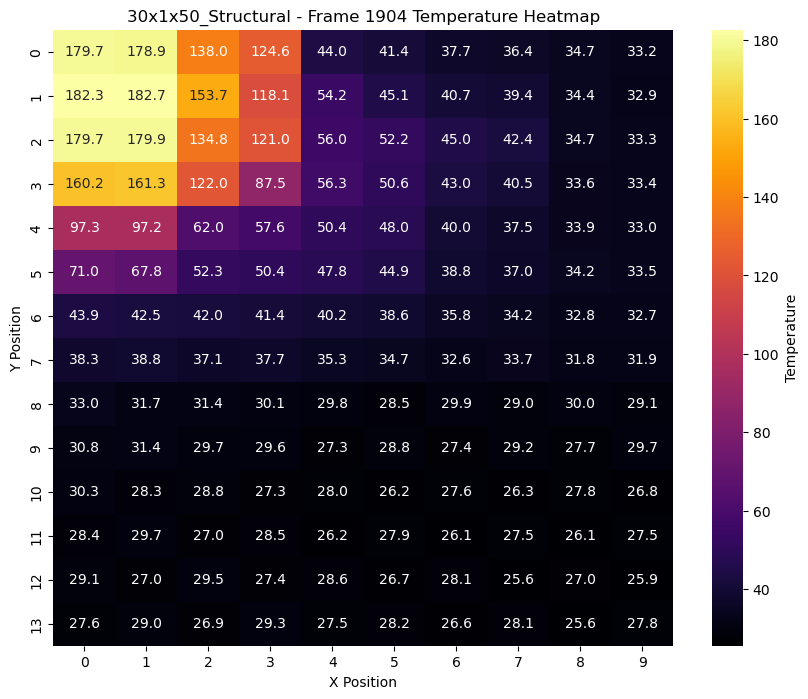

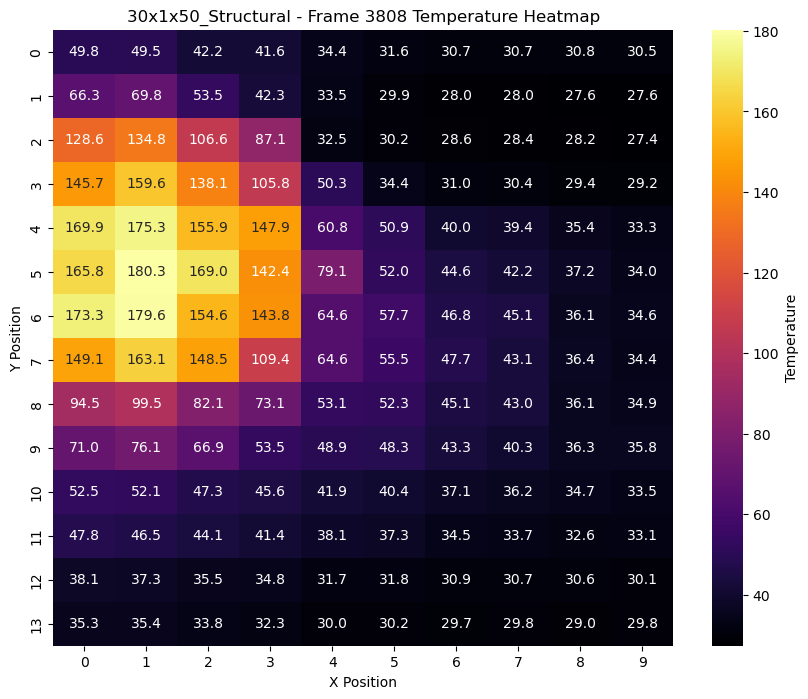

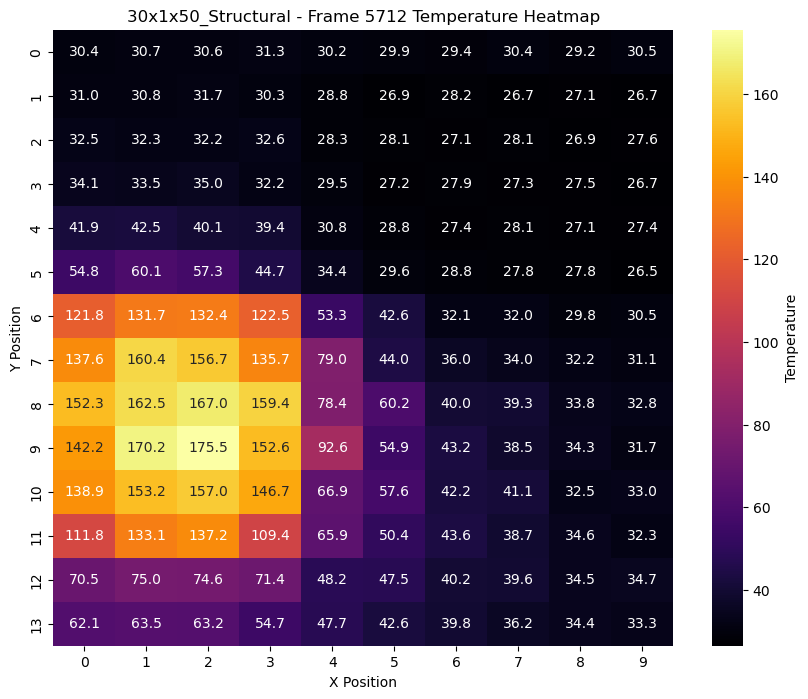

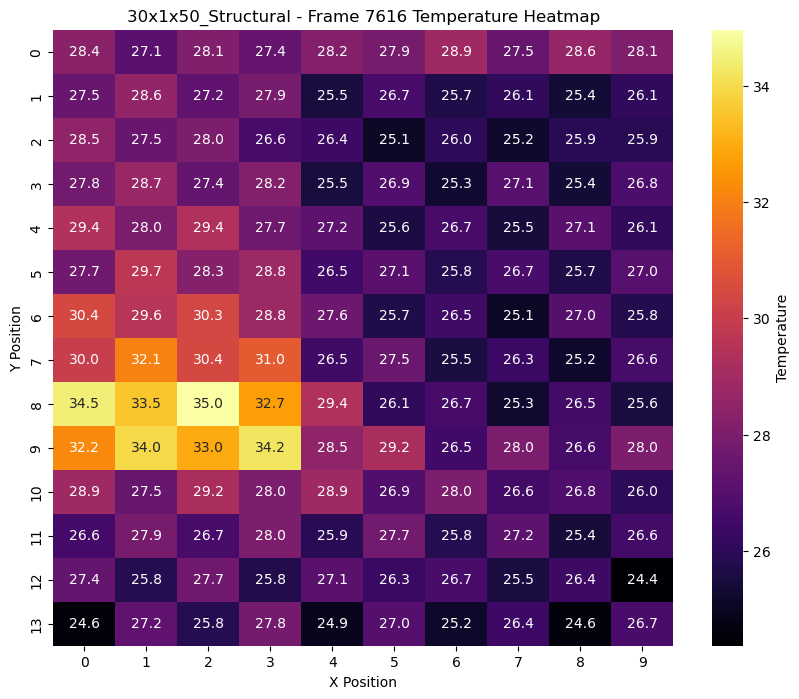

2. Analyzing temperature distribution...


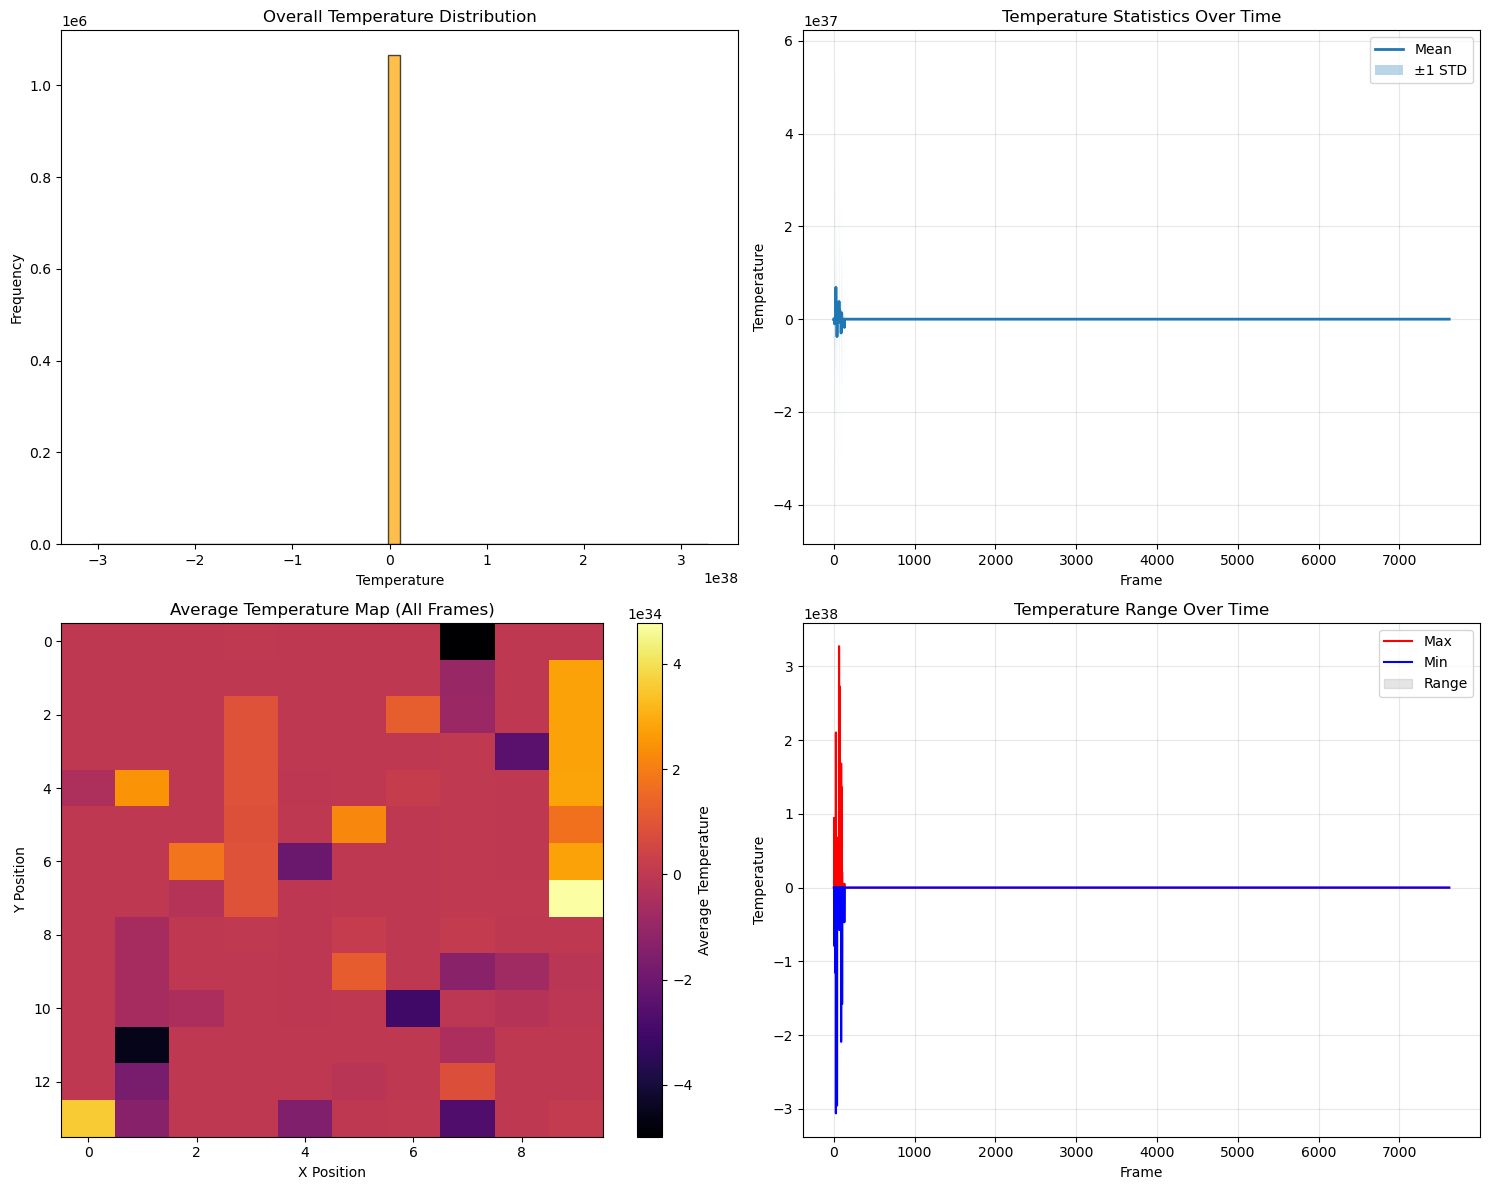

3. Performing spatial analysis...


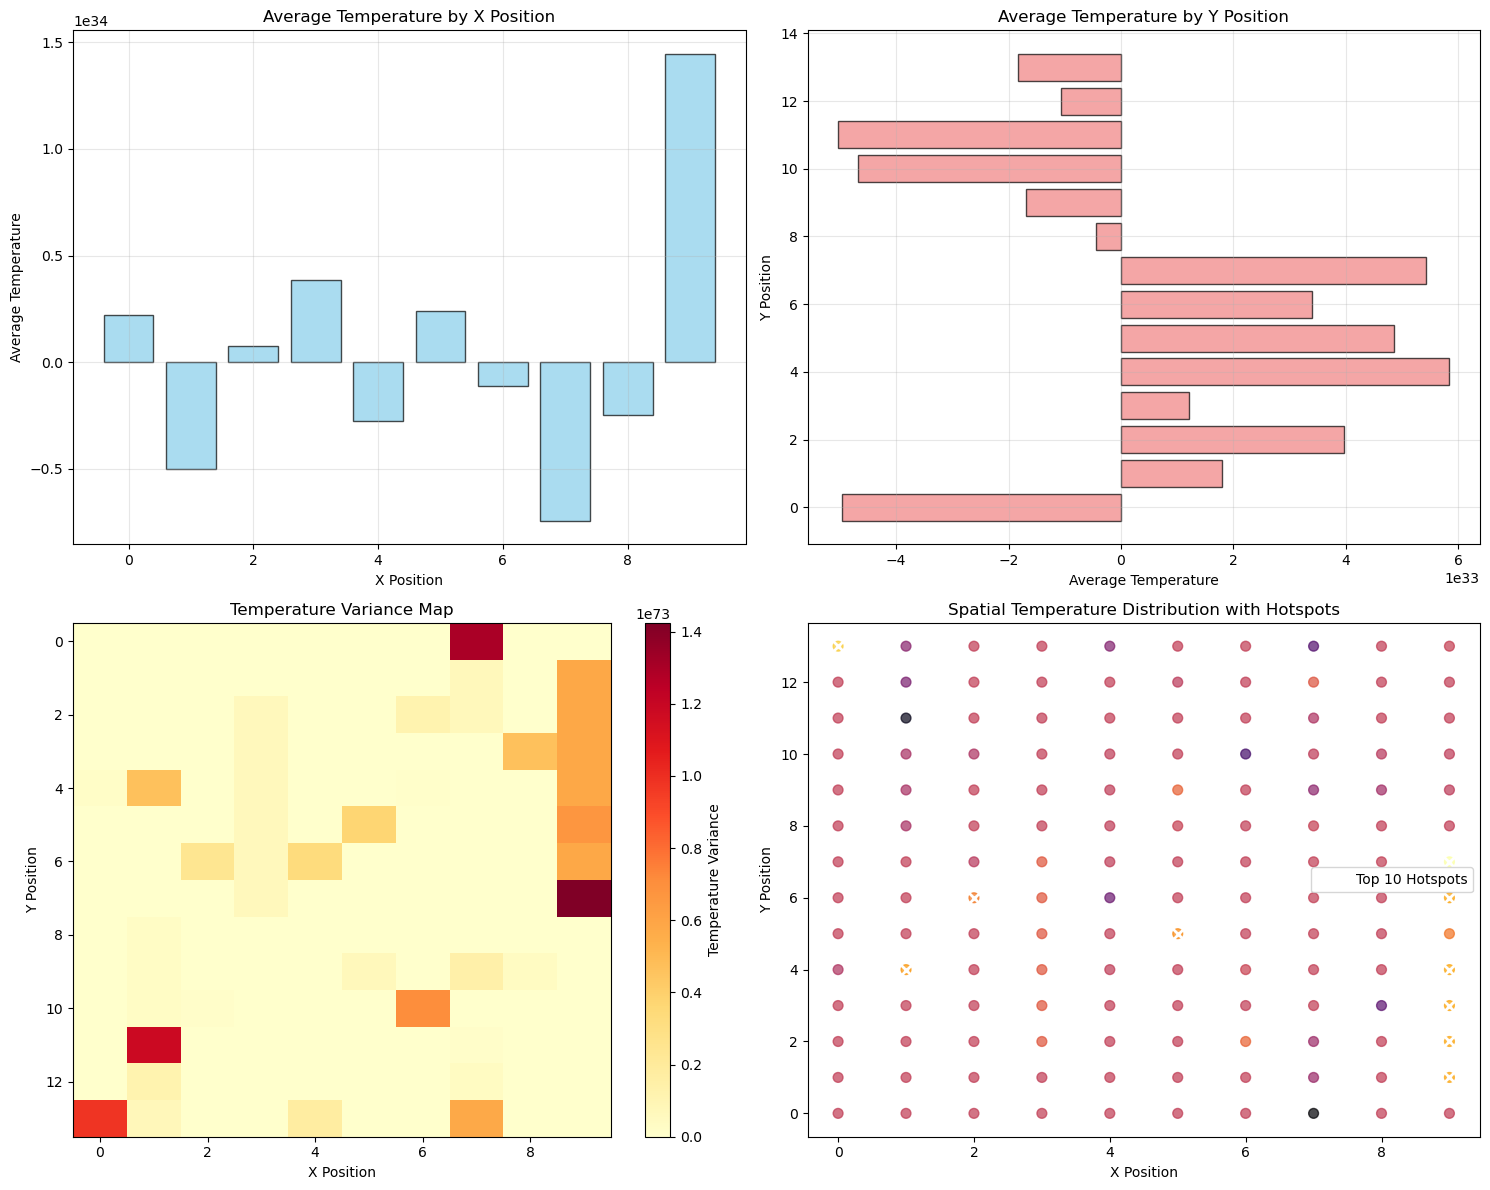

4. Analyzing temporal patterns...


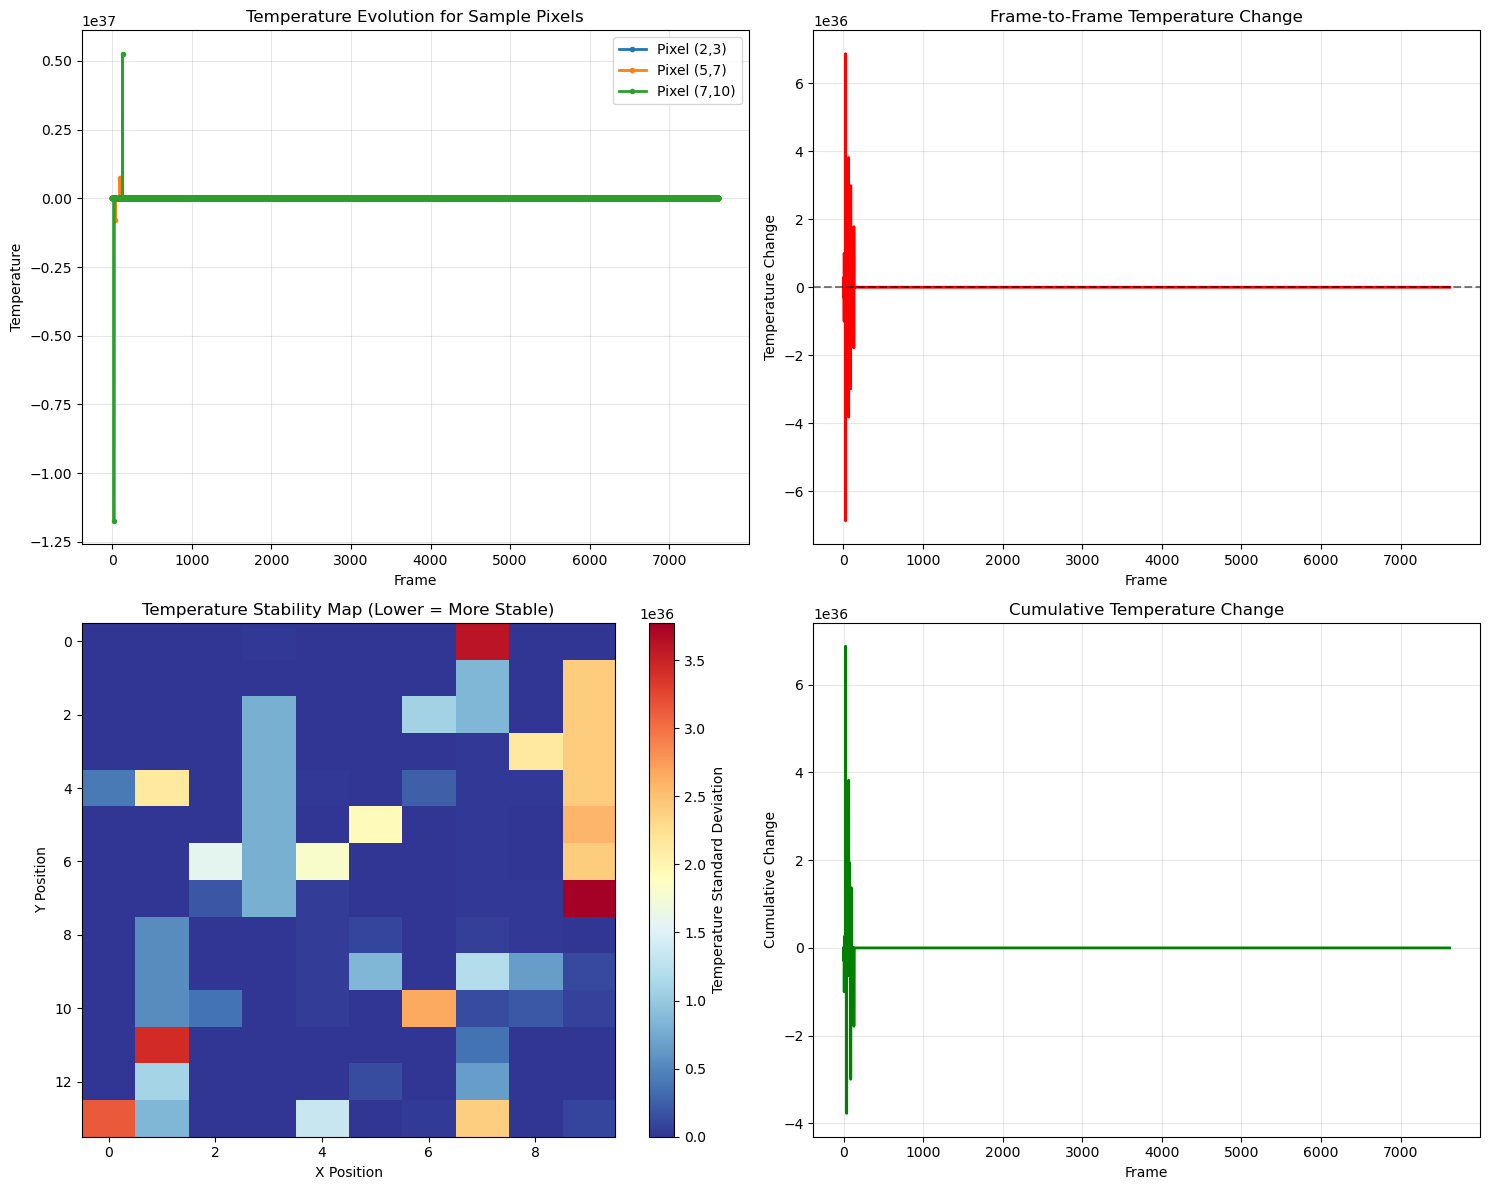

5. Creating interactive visualization...



Comprehensive analysis complete!
Files generated in: thermal_analysis_20250723_222845
- Frame heatmaps (PNG)
- Temperature distribution analysis (PNG)
- Spatial analysis (PNG)
- Temporal analysis (PNG)
- Interactive heatmap (HTML)
- Analysis summary (JSON)

Dataset Summary:
Frames: 7617
Dimensions: 10×14
Temperature Range: -306065920000000005627575581828802674688.00 - 327333389999999988116892644627120652288.00

Comparing 4 datasets...
Loaded data: 1066380 rows
Dimensions: 7617 frames × 14×10 pixels
Temperature range: -306065920000000005627575581828802674688.00 - 327333389999999988116892644627120652288.00
Loaded data: 1533600 rows
Dimensions: 10224 frames × 15×10 pixels
Temperature range: -58322174999999997783200703198451990528.00 - 189073249999999974518405951956849786880.00
Loaded data: 4851630 rows
Dimensions: 15402 frames × 15×21 pixels
Temperature range: -209030679999999994333535626524593487872.00 - 337967679999999981561361494055856373760.00
Loaded data: 5263965 rows
Dimensions: 16

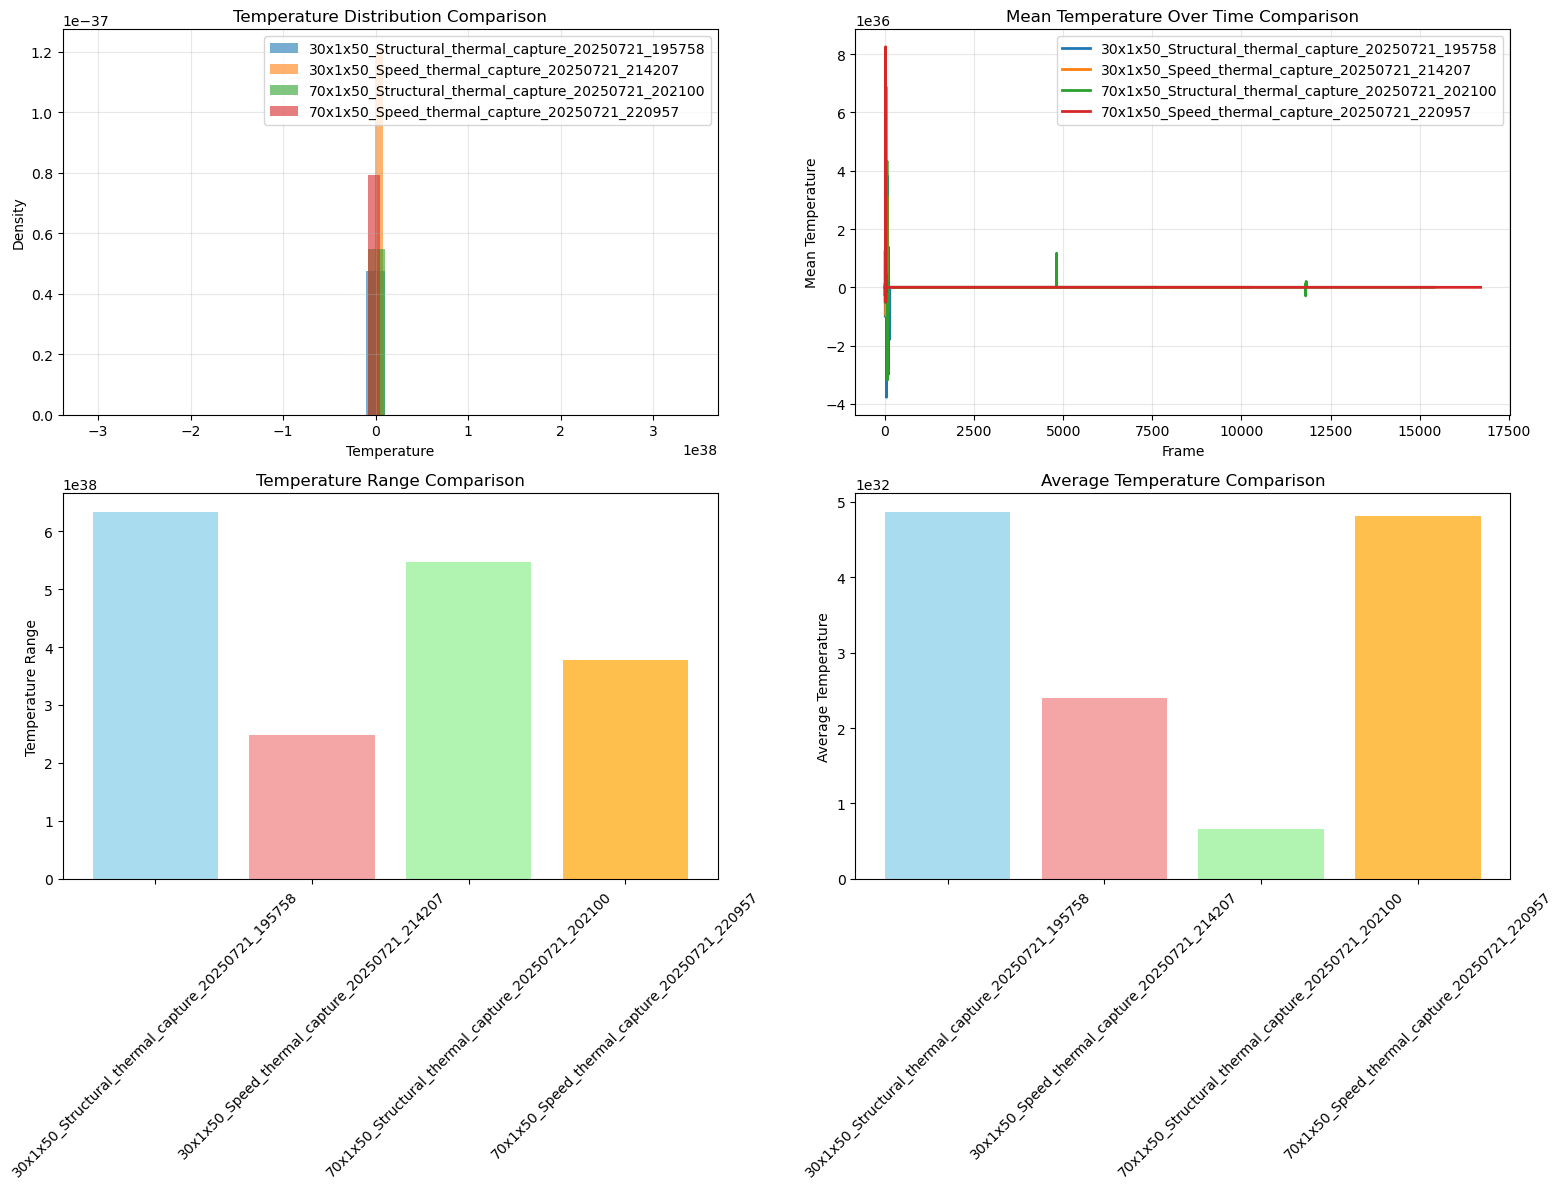

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from datetime import datetime

class ThermalCSVVisualizer:
    """Comprehensive visualization tool for thermal CSV data from cropped regions."""
    
    def __init__(self, csv_filepath, dataset_name=None):
        """
        Initialize the visualizer with CSV data.
        
        Args:
            csv_filepath (str): Path to the CSV file
            dataset_name (str): Name of the dataset for titles
        """
        self.csv_filepath = csv_filepath
        self.dataset_name = dataset_name or os.path.basename(csv_filepath)
        self.df = pd.read_csv(csv_filepath)
        
        # Get data dimensions
        self.frames = self.df['frame'].nunique()
        self.height = self.df['y'].nunique()
        self.width = self.df['x'].nunique()
        
        print(f"Loaded data: {len(self.df)} rows")
        print(f"Dimensions: {self.frames} frames × {self.height}×{self.width} pixels")
        print(f"Temperature range: {self.df['temperature'].min():.2f} - {self.df['temperature'].max():.2f}")
    
    def create_frame_heatmap(self, frame_number, save_path=None):
        """Create a heatmap for a specific frame."""
        frame_data = self.df[self.df['frame'] == frame_number]
        
        # Pivot to create 2D array
        heatmap_data = frame_data.pivot(index='y', columns='x', values='temperature')
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='inferno', 
                   cbar_kws={'label': 'Temperature'})
        plt.title(f'{self.dataset_name} - Frame {frame_number} Temperature Heatmap')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return heatmap_data
    
    def temperature_distribution_analysis(self, save_path=None):
        """Analyze temperature distribution across all frames."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Overall temperature distribution
        axes[0, 0].hist(self.df['temperature'], bins=50, alpha=0.7, color='orange', edgecolor='black')
        axes[0, 0].set_title('Overall Temperature Distribution')
        axes[0, 0].set_xlabel('Temperature')
        axes[0, 0].set_ylabel('Frequency')
        
        # Temperature statistics by frame
        frame_stats = self.df.groupby('frame')['temperature'].agg(['mean', 'std', 'min', 'max'])
        axes[0, 1].plot(frame_stats.index, frame_stats['mean'], label='Mean', linewidth=2)
        axes[0, 1].fill_between(frame_stats.index, 
                               frame_stats['mean'] - frame_stats['std'],
                               frame_stats['mean'] + frame_stats['std'], 
                               alpha=0.3, label='±1 STD')
        axes[0, 1].set_title('Temperature Statistics Over Time')
        axes[0, 1].set_xlabel('Frame')
        axes[0, 1].set_ylabel('Temperature')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Spatial temperature distribution (average across all frames)
        spatial_avg = self.df.groupby(['x', 'y'])['temperature'].mean().reset_index()
        spatial_pivot = spatial_avg.pivot(index='y', columns='x', values='temperature')
        
        im = axes[1, 0].imshow(spatial_pivot, cmap='inferno', aspect='auto')
        axes[1, 0].set_title('Average Temperature Map (All Frames)')
        axes[1, 0].set_xlabel('X Position')
        axes[1, 0].set_ylabel('Y Position')
        plt.colorbar(im, ax=axes[1, 0], label='Average Temperature')
        
        # Temperature range by frame
        axes[1, 1].plot(frame_stats.index, frame_stats['max'], label='Max', color='red')
        axes[1, 1].plot(frame_stats.index, frame_stats['min'], label='Min', color='blue')
        axes[1, 1].fill_between(frame_stats.index, frame_stats['min'], frame_stats['max'], 
                               alpha=0.2, color='gray', label='Range')
        axes[1, 1].set_title('Temperature Range Over Time')
        axes[1, 1].set_xlabel('Frame')
        axes[1, 1].set_ylabel('Temperature')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return frame_stats
    
    def spatial_analysis(self, save_path=None):
        """Analyze spatial patterns in temperature data."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Average temperature by X position
        x_avg = self.df.groupby('x')['temperature'].mean()
        axes[0, 0].bar(x_avg.index, x_avg.values, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Average Temperature by X Position')
        axes[0, 0].set_xlabel('X Position')
        axes[0, 0].set_ylabel('Average Temperature')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Average temperature by Y position
        y_avg = self.df.groupby('y')['temperature'].mean()
        axes[0, 1].barh(y_avg.index, y_avg.values, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[0, 1].set_title('Average Temperature by Y Position')
        axes[0, 1].set_xlabel('Average Temperature')
        axes[0, 1].set_ylabel('Y Position')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Temperature variance map
        spatial_var = self.df.groupby(['x', 'y'])['temperature'].var().reset_index()
        spatial_var_pivot = spatial_var.pivot(index='y', columns='x', values='temperature')
        
        im1 = axes[1, 0].imshow(spatial_var_pivot, cmap='YlOrRd', aspect='auto')
        axes[1, 0].set_title('Temperature Variance Map')
        axes[1, 0].set_xlabel('X Position')
        axes[1, 0].set_ylabel('Y Position')
        plt.colorbar(im1, ax=axes[1, 0], label='Temperature Variance')
        
        # Hotspot analysis (pixels with highest average temperature)
        spatial_avg = self.df.groupby(['x', 'y'])['temperature'].mean().reset_index()
        top_hotspots = spatial_avg.nlargest(10, 'temperature')
        
        axes[1, 1].scatter(spatial_avg['x'], spatial_avg['y'], 
                          c=spatial_avg['temperature'], cmap='inferno', s=50, alpha=0.7)
        axes[1, 1].scatter(top_hotspots['x'], top_hotspots['y'], 
                          c='white', s=100, marker='x', linewidths=2, label='Top 10 Hotspots')
        axes[1, 1].set_title('Spatial Temperature Distribution with Hotspots')
        axes[1, 1].set_xlabel('X Position')
        axes[1, 1].set_ylabel('Y Position')
        axes[1, 1].legend()
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return top_hotspots
    
    def temporal_analysis(self, save_path=None):
        """Analyze temporal patterns in the data."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Temperature evolution for specific pixels
        # Select a few representative pixels
        pixel_samples = [(self.width//4, self.height//4), 
                        (self.width//2, self.height//2), 
                        (3*self.width//4, 3*self.height//4)]
        
        for i, (px, py) in enumerate(pixel_samples):
            pixel_data = self.df[(self.df['x'] == px) & (self.df['y'] == py)]
            if not pixel_data.empty:
                axes[0, 0].plot(pixel_data['frame'], pixel_data['temperature'], 
                               label=f'Pixel ({px},{py})', linewidth=2, marker='o', markersize=3)
        
        axes[0, 0].set_title('Temperature Evolution for Sample Pixels')
        axes[0, 0].set_xlabel('Frame')
        axes[0, 0].set_ylabel('Temperature')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Frame-to-frame temperature change
        frame_means = self.df.groupby('frame')['temperature'].mean()
        frame_diff = frame_means.diff().dropna()
        
        axes[0, 1].plot(frame_diff.index[1:], frame_diff.values[1:], linewidth=2, color='red')
        axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[0, 1].set_title('Frame-to-Frame Temperature Change')
        axes[0, 1].set_xlabel('Frame')
        axes[0, 1].set_ylabel('Temperature Change')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Temperature stability analysis
        pixel_stability = self.df.groupby(['x', 'y'])['temperature'].std().reset_index()
        stability_pivot = pixel_stability.pivot(index='y', columns='x', values='temperature')
        
        im = axes[1, 0].imshow(stability_pivot, cmap='RdYlBu_r', aspect='auto')
        axes[1, 0].set_title('Temperature Stability Map (Lower = More Stable)')
        axes[1, 0].set_xlabel('X Position')
        axes[1, 0].set_ylabel('Y Position')
        plt.colorbar(im, ax=axes[1, 0], label='Temperature Standard Deviation')
        
        # Cumulative temperature change
        cumulative_change = frame_diff.cumsum()
        axes[1, 1].plot(cumulative_change.index, cumulative_change.values, linewidth=2, color='green')
        axes[1, 1].set_title('Cumulative Temperature Change')
        axes[1, 1].set_xlabel('Frame')
        axes[1, 1].set_ylabel('Cumulative Change')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return frame_diff, pixel_stability
    
    def create_interactive_heatmap(self, save_path=None):
        """Create an interactive heatmap using Plotly."""
        # Sample every 10th frame for performance
        sample_frames = range(0, self.frames, max(1, self.frames // 20))
        
        fig = go.Figure()
        
        for i, frame_num in enumerate(sample_frames):
            frame_data = self.df[self.df['frame'] == frame_num]
            heatmap_data = frame_data.pivot(index='y', columns='x', values='temperature')
            
            fig.add_trace(
                go.Heatmap(
                    z=heatmap_data.values,
                    x=heatmap_data.columns,
                    y=heatmap_data.index,
                    colorscale='Inferno',
                    name=f'Frame {frame_num}',
                    visible=(i == 0),
                    colorbar=dict(title="Temperature")
                )
            )
        
        # Create slider steps
        steps = []
        for i, frame_num in enumerate(sample_frames):
            step = dict(
                method="update",
                args=[{"visible": [False] * len(sample_frames)},
                      {"title": f"Thermal Heatmap - Frame {frame_num}"}],
                label=str(frame_num)
            )
            step["args"][0]["visible"][i] = True
            steps.append(step)
        
        sliders = [dict(
            active=0,
            currentvalue={"prefix": "Frame: "},
            pad={"t": 50},
            steps=steps
        )]
        
        fig.update_layout(
            sliders=sliders,
            title=f"Interactive Thermal Heatmap - {self.dataset_name}",
            xaxis_title="X Position",
            yaxis_title="Y Position"
        )
        
        if save_path:
            fig.write_html(save_path)
        
        fig.show()
        return fig
    
    def generate_comprehensive_report(self, output_dir=None):
        """Generate a comprehensive visualization report."""
        if output_dir is None:
            output_dir = f"thermal_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"Generating comprehensive thermal analysis report...")
        print(f"Output directory: {output_dir}")
        
        # Generate all visualizations
        print("1. Creating frame heatmaps...")
        sample_frames = [0, self.frames//4, self.frames//2, 3*self.frames//4, self.frames-1]
        for frame in sample_frames:
            if frame < self.frames:
                self.create_frame_heatmap(
                    frame, 
                    save_path=os.path.join(output_dir, f"frame_{frame}_heatmap.png")
                )
                plt.close()
        
        print("2. Analyzing temperature distribution...")
        frame_stats = self.temperature_distribution_analysis(
            save_path=os.path.join(output_dir, "temperature_distribution.png")
        )
        plt.close()
        
        print("3. Performing spatial analysis...")
        hotspots = self.spatial_analysis(
            save_path=os.path.join(output_dir, "spatial_analysis.png")
        )
        plt.close()
        
        print("4. Analyzing temporal patterns...")
        frame_diff, pixel_stability = self.temporal_analysis(
            save_path=os.path.join(output_dir, "temporal_analysis.png")
        )
        plt.close()
        
        print("5. Creating interactive visualization...")
        self.create_interactive_heatmap(
            save_path=os.path.join(output_dir, "interactive_heatmap.html")
        )
        
        # Save statistical summary
        summary = {
            'dataset_info': {
                'name': self.dataset_name,
                'total_pixels': len(self.df),
                'frames': self.frames,
                'dimensions': f"{self.width}×{self.height}",
                'temperature_range': f"{self.df['temperature'].min():.2f} - {self.df['temperature'].max():.2f}"
            },
            'temperature_stats': {
                'overall_mean': float(self.df['temperature'].mean()),
                'overall_std': float(self.df['temperature'].std()),
                'overall_min': float(self.df['temperature'].min()),
                'overall_max': float(self.df['temperature'].max())
            },
            'hotspots': hotspots.to_dict('records')[:5],  # Top 5 hotspots
            'analysis_timestamp': datetime.now().isoformat()
        }
        
        import json
        with open(os.path.join(output_dir, "analysis_summary.json"), 'w') as f:
            json.dump(summary, f, indent=2)
        
        print(f"\nComprehensive analysis complete!")
        print(f"Files generated in: {output_dir}")
        print("- Frame heatmaps (PNG)")
        print("- Temperature distribution analysis (PNG)")
        print("- Spatial analysis (PNG)")
        print("- Temporal analysis (PNG)")
        print("- Interactive heatmap (HTML)")
        print("- Analysis summary (JSON)")
        
        return summary

def visualize_multiple_datasets(csv_file_paths, output_dir="multi_dataset_analysis"):
    """Compare multiple datasets side by side."""
    os.makedirs(output_dir, exist_ok=True)
    
    visualizers = {}
    for file_path in csv_file_paths:
        dataset_name = os.path.basename(file_path).replace('_pixel_data.csv', '')
        visualizers[dataset_name] = ThermalCSVVisualizer(file_path, dataset_name)
    
    # Comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Temperature distributions comparison
    for name, viz in visualizers.items():
        axes[0, 0].hist(viz.df['temperature'], bins=30, alpha=0.6, label=name, density=True)
    axes[0, 0].set_title('Temperature Distribution Comparison')
    axes[0, 0].set_xlabel('Temperature')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Frame statistics comparison
    for name, viz in visualizers.items():
        frame_stats = viz.df.groupby('frame')['temperature'].mean()
        axes[0, 1].plot(frame_stats.index, frame_stats.values, label=name, linewidth=2)
    axes[0, 1].set_title('Mean Temperature Over Time Comparison')
    axes[0, 1].set_xlabel('Frame')
    axes[0, 1].set_ylabel('Mean Temperature')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Temperature range comparison
    ranges = []
    names = []
    for name, viz in visualizers.items():
        temp_range = viz.df['temperature'].max() - viz.df['temperature'].min()
        ranges.append(temp_range)
        names.append(name)
    
    axes[1, 0].bar(names, ranges, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'][:len(names)])
    axes[1, 0].set_title('Temperature Range Comparison')
    axes[1, 0].set_ylabel('Temperature Range')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Average temperature comparison
    avg_temps = []
    for name, viz in visualizers.items():
        avg_temps.append(viz.df['temperature'].mean())
    
    axes[1, 1].bar(names, avg_temps, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'][:len(names)])
    axes[1, 1].set_title('Average Temperature Comparison')
    axes[1, 1].set_ylabel('Average Temperature')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "dataset_comparison.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    return visualizers

# Example usage
if __name__ == "__main__":
    # Example for single dataset
    csv_file = "thermal_cropped_output/30x1x50_Structural/30x1x50_Structural_thermal_capture_20250721_195758_pixel_data.csv"
    
    if os.path.exists(csv_file):
        # Create visualizer
        viz = ThermalCSVVisualizer(csv_file, "30x1x50_Structural")
        
        # Generate comprehensive report
        summary = viz.generate_comprehensive_report()
        
        print("\nDataset Summary:")
        print(f"Frames: {summary['dataset_info']['frames']}")
        print(f"Dimensions: {summary['dataset_info']['dimensions']}")
        print(f"Temperature Range: {summary['dataset_info']['temperature_range']}")
    else:
        print(f"CSV file not found: {csv_file}")
        print("Please run the cropping script first to generate CSV files.")
    
    # Example for multiple datasets comparison
    csv_files = [
        "thermal_cropped_output/30x1x50_Structural/30x1x50_Structural_thermal_capture_20250721_195758_pixel_data.csv",
        "thermal_cropped_output/30x1x50_Speed/30x1x50_Speed_thermal_capture_20250721_214207_pixel_data.csv",
        "thermal_cropped_output/70x1x50_Structural/70x1x50_Structural_thermal_capture_20250721_202100_pixel_data.csv",
        "thermal_cropped_output/70x1x50_Speed/70x1x50_Speed_thermal_capture_20250721_220957_pixel_data.csv"
    ]
    
    # Filter existing files
    existing_files = [f for f in csv_files if os.path.exists(f)]
    
    if len(existing_files) > 1:
        print(f"\nComparing {len(existing_files)} datasets...")
        visualize_multiple_datasets(existing_files)
    else:
        print("Multiple CSV files not found for comparison.")

Starting thermal data visualization with preprocessing...
Temperature filter range: 15°C - 230°C
Creating preprocessing comparison plots...
Loaded thermal_cropped_output\30x1x50_Structural\30x1x50_Structural_thermal_capture_20250721_195758_pixel_data.csv
Original shape: (1066380, 7)
Original temperature range: -336636519999999974996509642843802828800.00 - 327333389999999988116892644627120652288.00°C
Temperature filter applied: 15°C - 230°C
Removed 10,708 data points (1.00%)
Filtered shape: (1055672, 7)
Filtered temperature range: 19.72 - 205.26°C
Remaining frames: 7568
Removed frame IDs: [0, 5, 6, 7, 10, 11, 16, 24, 25, 27, 28, 31, 32, 33, 37, 38, 39, 43, 46, 49, 53, 58, 63, 68, 71, 72, 78, 80, 81, 85, 87, 90, 101, 102, 104, 105, 110, 111, 113, 116, 117, 121, 125, 128, 129, 130, 136, 137, 6045]
Loaded thermal_cropped_output\30x1x50_Speed\30x1x50_Speed_thermal_capture_20250721_214207_pixel_data.csv
Original shape: (1635840, 7)
Original temperature range: -5832217499999999778320070319845

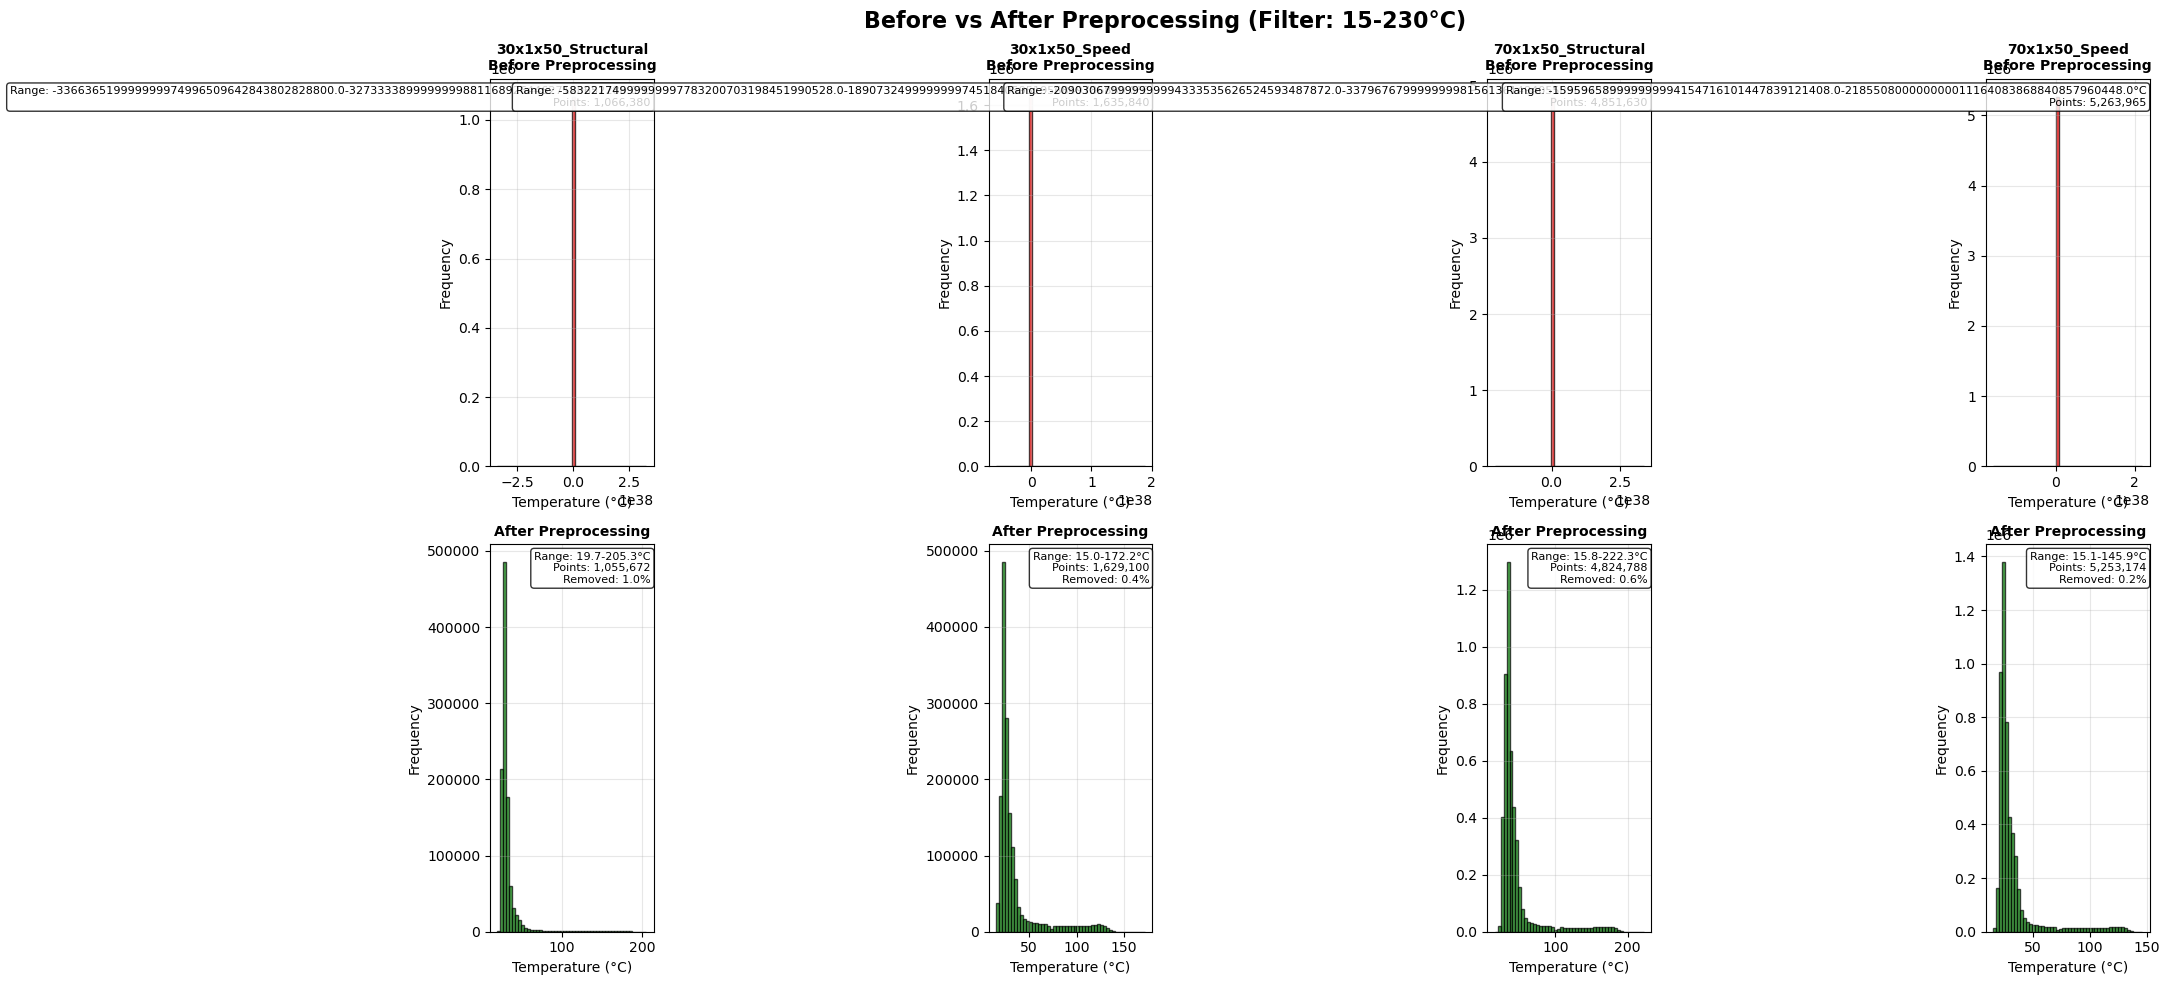


Creating thermal heatmaps with preprocessing...

Processing 30x1x50_Structural
Loaded thermal_cropped_output\30x1x50_Structural\30x1x50_Structural_thermal_capture_20250721_195758_pixel_data.csv
Original shape: (1066380, 7)
Original temperature range: -336636519999999974996509642843802828800.00 - 327333389999999988116892644627120652288.00°C
Temperature filter applied: 15°C - 230°C
Removed 10,708 data points (1.00%)
Filtered shape: (1055672, 7)
Filtered temperature range: 19.72 - 205.26°C
Remaining frames: 7568
Removed frame IDs: [0, 5, 6, 7, 10, 11, 16, 24, 25, 27, 28, 31, 32, 33, 37, 38, 39, 43, 46, 49, 53, 58, 63, 68, 71, 72, 78, 80, 81, 85, 87, 90, 101, 102, 104, 105, 110, 111, 113, 116, 117, 121, 125, 128, 129, 130, 136, 137, 6045]
Saved preprocessed data: thermal_cropped_output\preprocessed_data\30x1x50_Structural_thermal_capture_20250721_195758_pixel_data_preprocessed.csv
Saved preprocessing report: thermal_cropped_output\preprocessed_data\30x1x50_Structural_thermal_capture_20250

C:\Users\hakim\AppData\Local\Temp\ipykernel_17760\4245730561.py:306: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved combined plot: thermal_cropped_output\visualizations\all_datasets_thermal_comparison_preprocessed.png
Saved preprocessing summary: thermal_cropped_output\preprocessed_data\preprocessing_summary.json


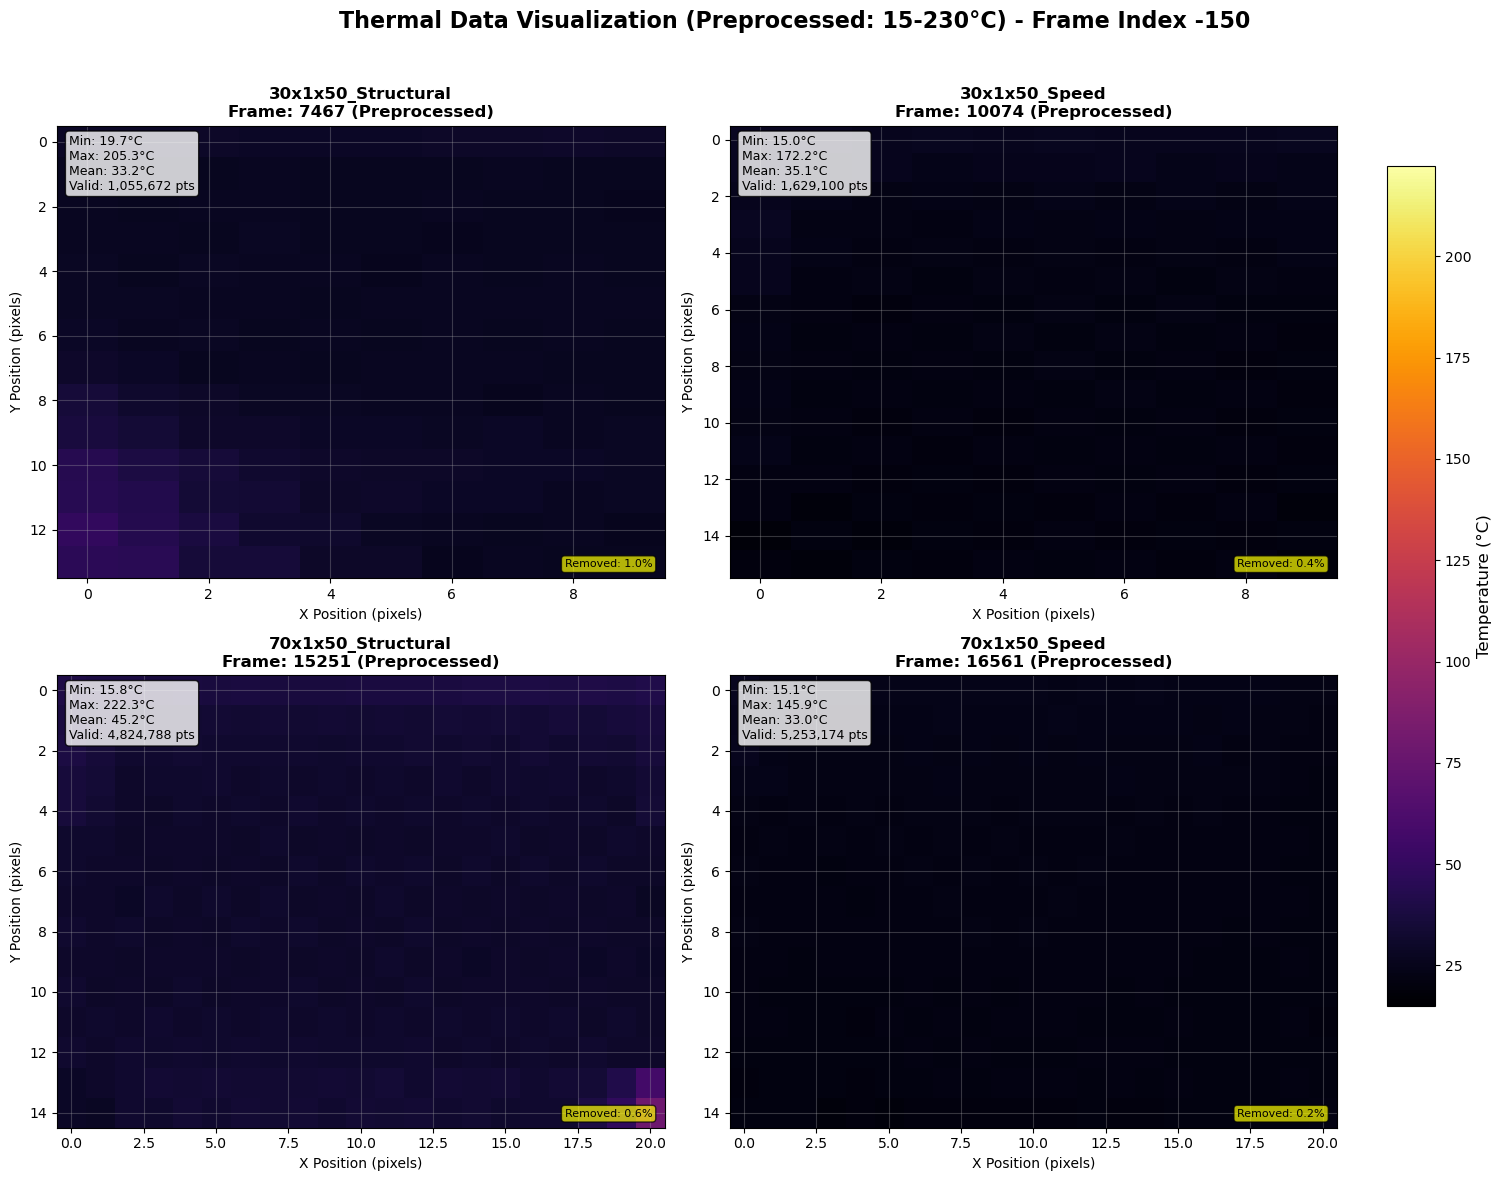


Creating temperature distribution plots with preprocessing...
Loaded thermal_cropped_output\30x1x50_Structural\30x1x50_Structural_thermal_capture_20250721_195758_pixel_data.csv
Original shape: (1066380, 7)
Original temperature range: -336636519999999974996509642843802828800.00 - 327333389999999988116892644627120652288.00°C
Temperature filter applied: 15°C - 230°C
Removed 10,708 data points (1.00%)
Filtered shape: (1055672, 7)
Filtered temperature range: 19.72 - 205.26°C
Remaining frames: 7568
Removed frame IDs: [0, 5, 6, 7, 10, 11, 16, 24, 25, 27, 28, 31, 32, 33, 37, 38, 39, 43, 46, 49, 53, 58, 63, 68, 71, 72, 78, 80, 81, 85, 87, 90, 101, 102, 104, 105, 110, 111, 113, 116, 117, 121, 125, 128, 129, 130, 136, 137, 6045]
Loaded thermal_cropped_output\30x1x50_Speed\30x1x50_Speed_thermal_capture_20250721_214207_pixel_data.csv
Original shape: (1635840, 7)
Original temperature range: -58322174999999997783200703198451990528.00 - 189073249999999974518405951956849786880.00°C
Temperature filter 

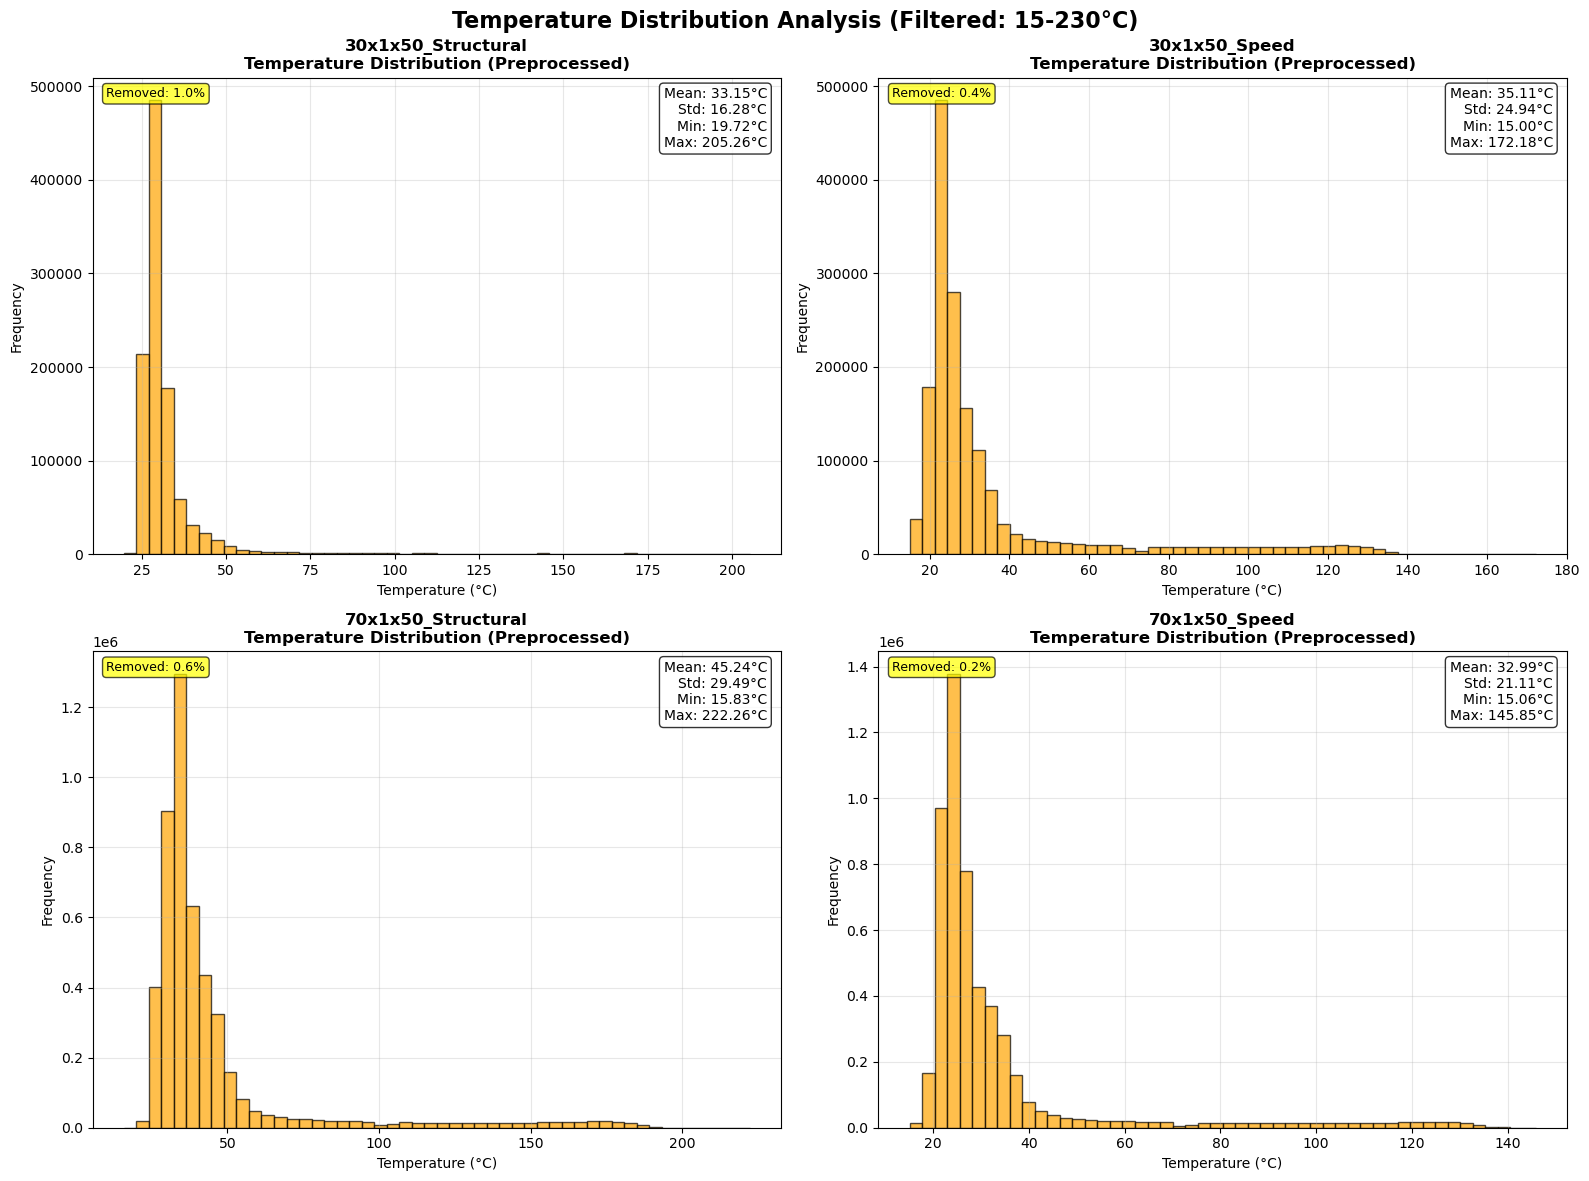

Saved distribution plot: thermal_cropped_output\visualizations\temperature_distributions.png


<Figure size 640x480 with 0 Axes>


Creating temporal analysis with preprocessing...
Loaded thermal_cropped_output\30x1x50_Structural\30x1x50_Structural_thermal_capture_20250721_195758_pixel_data.csv
Original shape: (1066380, 7)
Original temperature range: -336636519999999974996509642843802828800.00 - 327333389999999988116892644627120652288.00°C
Temperature filter applied: 15°C - 230°C
Removed 10,708 data points (1.00%)
Filtered shape: (1055672, 7)
Filtered temperature range: 19.72 - 205.26°C
Remaining frames: 7568
Removed frame IDs: [0, 5, 6, 7, 10, 11, 16, 24, 25, 27, 28, 31, 32, 33, 37, 38, 39, 43, 46, 49, 53, 58, 63, 68, 71, 72, 78, 80, 81, 85, 87, 90, 101, 102, 104, 105, 110, 111, 113, 116, 117, 121, 125, 128, 129, 130, 136, 137, 6045]
Loaded thermal_cropped_output\30x1x50_Speed\30x1x50_Speed_thermal_capture_20250721_214207_pixel_data.csv
Original shape: (1635840, 7)
Original temperature range: -58322174999999997783200703198451990528.00 - 189073249999999974518405951956849786880.00°C
Temperature filter applied: 15°C

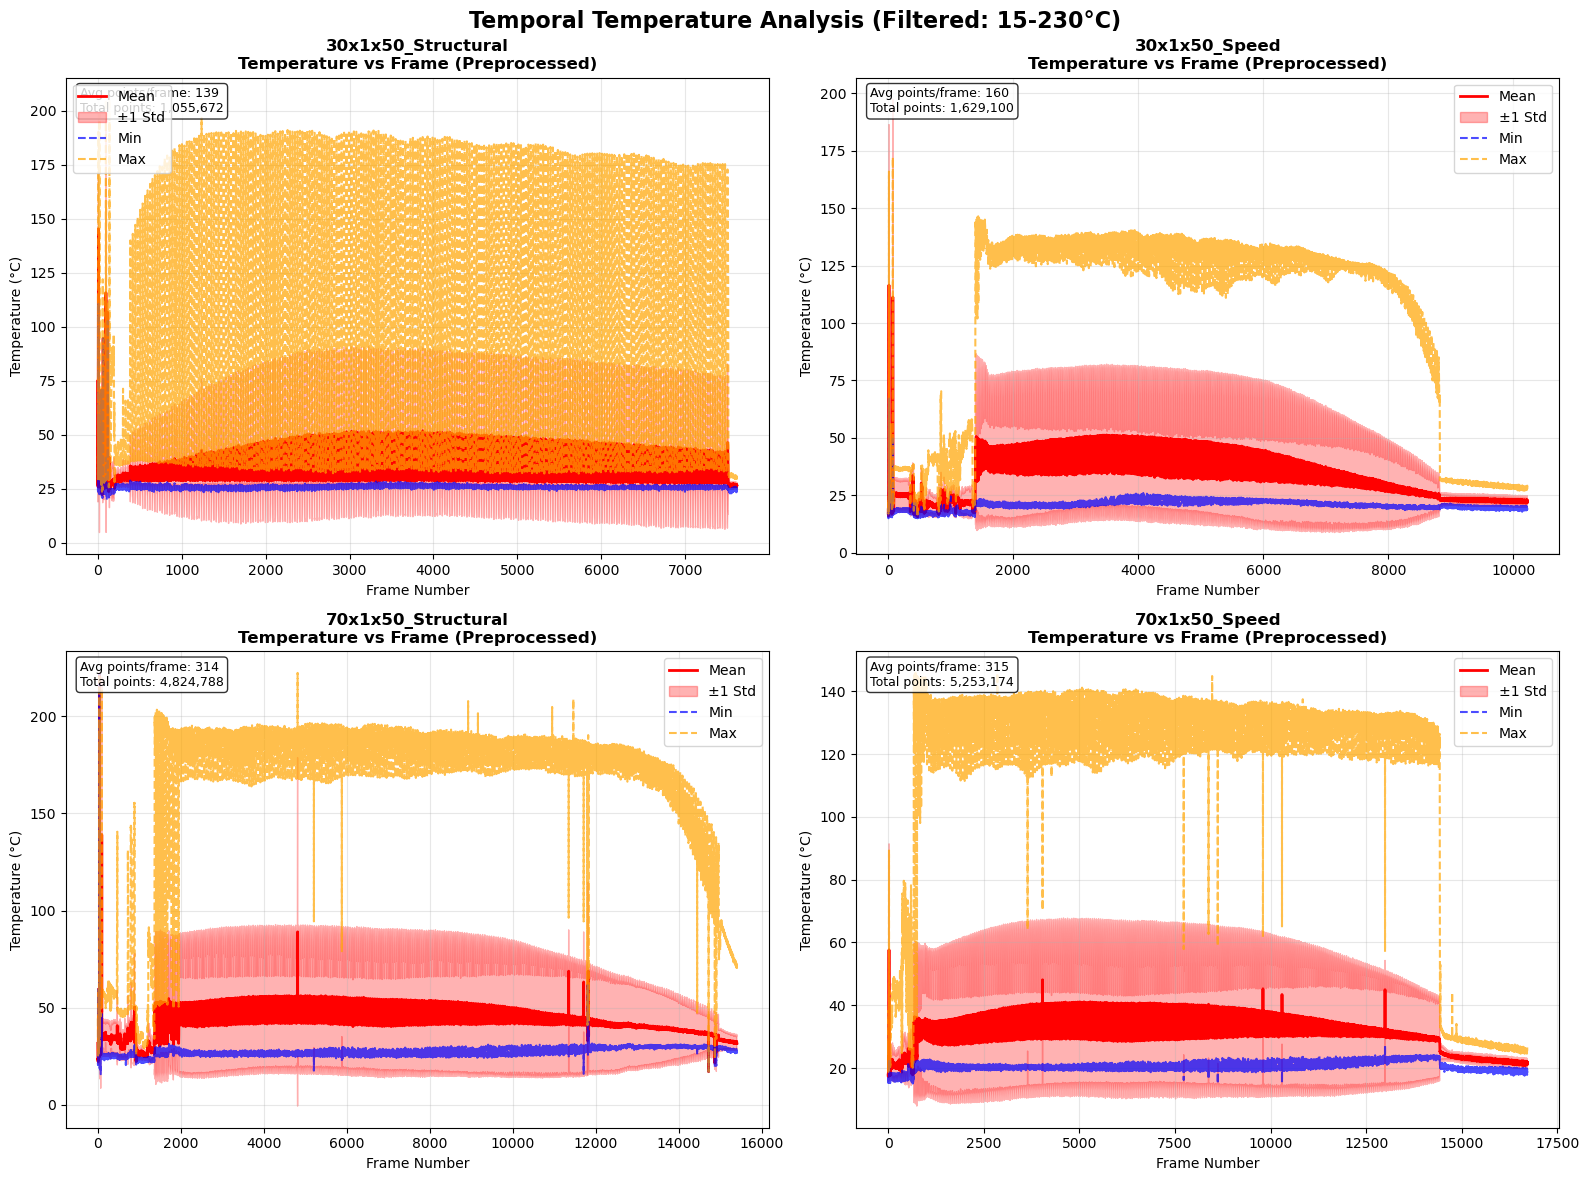


Generating summary report with preprocessing...
Loaded thermal_cropped_output\30x1x50_Structural\30x1x50_Structural_thermal_capture_20250721_195758_pixel_data.csv
Original shape: (1066380, 7)
Original temperature range: -336636519999999974996509642843802828800.00 - 327333389999999988116892644627120652288.00°C
Temperature filter applied: 15°C - 230°C
Removed 10,708 data points (1.00%)
Filtered shape: (1055672, 7)
Filtered temperature range: 19.72 - 205.26°C
Remaining frames: 7568
Removed frame IDs: [0, 5, 6, 7, 10, 11, 16, 24, 25, 27, 28, 31, 32, 33, 37, 38, 39, 43, 46, 49, 53, 58, 63, 68, 71, 72, 78, 80, 81, 85, 87, 90, 101, 102, 104, 105, 110, 111, 113, 116, 117, 121, 125, 128, 129, 130, 136, 137, 6045]
Loaded thermal_cropped_output\30x1x50_Speed\30x1x50_Speed_thermal_capture_20250721_214207_pixel_data.csv
Original shape: (1635840, 7)
Original temperature range: -58322174999999997783200703198451990528.00 - 189073249999999974518405951956849786880.00°C
Temperature filter applied: 15°C 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import json

def load_thermal_csv_data(csv_path, temp_min=25, temp_max=230):
    """
    Load thermal CSV data, preprocess by filtering temperature range, and return cleaned DataFrame.
    
    Args:
        csv_path (str): Path to CSV file
        temp_min (float): Minimum acceptable temperature (default: 25°C)
        temp_max (float): Maximum acceptable temperature (default: 230°C)
    """
    df = pd.read_csv(csv_path)
    
    print(f"Loaded {csv_path}")
    print(f"Original shape: {df.shape}")
    print(f"Original temperature range: {df['temperature'].min():.2f} - {df['temperature'].max():.2f}°C")
    
    # Store original statistics
    original_count = len(df)
    original_temp_range = (df['temperature'].min(), df['temperature'].max())
    
    # Filter temperature range
    mask = (df['temperature'] >= temp_min) & (df['temperature'] <= temp_max)
    df_filtered = df[mask].copy()
    
    # Calculate filtering statistics
    removed_count = original_count - len(df_filtered)
    removal_percentage = (removed_count / original_count) * 100
    
    print(f"Temperature filter applied: {temp_min}°C - {temp_max}°C")
    print(f"Removed {removed_count:,} data points ({removal_percentage:.2f}%)")
    print(f"Filtered shape: {df_filtered.shape}")
    print(f"Filtered temperature range: {df_filtered['temperature'].min():.2f} - {df_filtered['temperature'].max():.2f}°C")
    print(f"Remaining frames: {df_filtered['frame'].nunique()}")
    
    # Check if any frames were completely removed
    original_frames = set(df['frame'].unique())
    remaining_frames = set(df_filtered['frame'].unique())
    removed_frames = original_frames - remaining_frames
    
    if removed_frames:
        print(f"Warning: {len(removed_frames)} frames completely removed due to temperature filtering")
        print(f"Removed frame IDs: {sorted(list(removed_frames))}")
    
    # Add preprocessing metadata to the dataframe
    df_filtered.attrs = {
        'preprocessing': {
            'temp_filter_min': temp_min,
            'temp_filter_max': temp_max,
            'original_count': original_count,
            'filtered_count': len(df_filtered),
            'removed_count': removed_count,
            'removal_percentage': removal_percentage,
            'original_temp_range': original_temp_range,
            'filtered_temp_range': (df_filtered['temperature'].min(), df_filtered['temperature'].max())
        }
    }
    
    return df_filtered

def create_thermal_heatmap(df, frame_idx=-150, title_suffix=""):
    """Create a thermal heatmap for a specific frame from preprocessed data."""
    # Get the specified frame (default to -150 or last available)
    available_frames = sorted(df['frame'].unique())
    if frame_idx < 0:
        target_frame = available_frames[frame_idx] if len(available_frames) > abs(frame_idx) else available_frames[-1]
    else:
        target_frame = frame_idx if frame_idx in available_frames else available_frames[0]
    
    frame_data = df[df['frame'] == target_frame]
    
    # Check if frame has data after preprocessing
    if len(frame_data) == 0:
        print(f"Warning: No data remaining in frame {target_frame} after preprocessing")
        # Try to find the nearest frame with data
        for offset in range(1, min(10, len(available_frames))):
            if frame_idx - offset >= 0 and available_frames[frame_idx - offset] in df['frame'].values:
                target_frame = available_frames[frame_idx - offset]
                frame_data = df[df['frame'] == target_frame]
                break
            elif frame_idx + offset < len(available_frames) and available_frames[frame_idx + offset] in df['frame'].values:
                target_frame = available_frames[frame_idx + offset]
                frame_data = df[df['frame'] == target_frame]
                break
    
    # Create pivot table for heatmap - handle missing data
    heatmap_data = frame_data.pivot_table(index='y', columns='x', values='temperature', fill_value=np.nan)
    
    return heatmap_data, target_frame

def save_preprocessed_data(df, original_csv_path, output_dir):
    """Save preprocessed data to new CSV file with preprocessing info."""
    # Create preprocessed filename
    original_filename = Path(original_csv_path).stem
    preprocessed_filename = f"{original_filename}_preprocessed.csv"
    preprocessed_path = os.path.join(output_dir, preprocessed_filename)
    
    # Save preprocessed CSV
    df.to_csv(preprocessed_path, index=False)
    
    # Save preprocessing report
    report_filename = f"{original_filename}_preprocessing_report.json"
    report_path = os.path.join(output_dir, report_filename)
    
    preprocessing_report = {
        'original_file': str(original_csv_path),
        'preprocessed_file': preprocessed_path,
        'processing_timestamp': pd.Timestamp.now().isoformat(),
        'preprocessing_steps': {
            'temperature_filtering': {
                'min_temp': df.attrs['preprocessing']['temp_filter_min'],
                'max_temp': df.attrs['preprocessing']['temp_filter_max'],
                'original_data_points': df.attrs['preprocessing']['original_count'],
                'filtered_data_points': df.attrs['preprocessing']['filtered_count'],
                'removed_data_points': df.attrs['preprocessing']['removed_count'],
                'removal_percentage': df.attrs['preprocessing']['removal_percentage']
            }
        },
        'final_statistics': {
            'total_frames': df['frame'].nunique(),
            'total_data_points': len(df),
            'temperature_range': {
                'min': float(df['temperature'].min()),
                'max': float(df['temperature'].max()),
                'mean': float(df['temperature'].mean()),
                'std': float(df['temperature'].std())
            },
            'spatial_coverage': {
                'x_range': [int(df['x'].min()), int(df['x'].max())],
                'y_range': [int(df['y'].min()), int(df['y'].max())],
                'unique_pixels_per_frame': len(df[df['frame'] == df['frame'].iloc[0]])
            }
        }
    }
    
    with open(report_path, 'w') as f:
        json.dump(preprocessing_report, f, indent=2)
    
    print(f"Saved preprocessed data: {preprocessed_path}")
    print(f"Saved preprocessing report: {report_path}")
    
    return preprocessed_path, report_path
def visualize_all_datasets(base_dir="thermal_cropped_output", frame_idx=-150, save_individual=True, 
                          temp_min=25, temp_max=230, save_preprocessed=True):
    """
    Visualize all four thermal datasets with preprocessing in a single tight plot and save individual plots.
    
    Args:
        base_dir (str): Base directory containing the cropped datasets
        frame_idx (int): Frame index to visualize (negative for counting from end)
        save_individual (bool): Whether to save individual plots for each dataset
        temp_min (float): Minimum acceptable temperature for preprocessing
        temp_max (float): Maximum acceptable temperature for preprocessing
        save_preprocessed (bool): Whether to save preprocessed CSV files
    """
    
    # Dataset configuration
    datasets = {
        "30x1x50_Structural": "30x1x50_Structural",
        "30x1x50_Speed": "30x1x50_Speed", 
        "70x1x50_Structural": "70x1x50_Structural",
        "70x1x50_Speed": "70x1x50_Speed"
    }
    
    # Create output directory for visualizations
    viz_output_dir = os.path.join(base_dir, "visualizations")
    preprocessed_output_dir = os.path.join(base_dir, "preprocessed_data")
    os.makedirs(viz_output_dir, exist_ok=True)
    os.makedirs(preprocessed_output_dir, exist_ok=True)
    
    # Set up the combined plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Thermal Data Visualization (Preprocessed: {temp_min}-{temp_max}°C) - Frame Index {frame_idx}', 
                fontsize=16, fontweight='bold')
    
    # Flatten axes for easier iteration
    axes_flat = axes.flatten()
    
    # Store data for global temperature scale
    all_temps = []
    heatmap_data_list = []
    dataset_info = []
    preprocessing_summary = {}
    
    # First pass: collect all temperature data for consistent colormap
    for i, (dataset_key, dataset_name) in enumerate(datasets.items()):
        csv_path = os.path.join(base_dir, dataset_name, f"*_pixel_data.csv")
        csv_files = list(Path(base_dir).glob(f"{dataset_name}/*_pixel_data.csv"))
        
        if not csv_files:
            print(f"Warning: No CSV file found for {dataset_name}")
            continue
            
        csv_path = csv_files[0]
        print(f"\n{'='*60}")
        print(f"Processing {dataset_key}")
        print(f"{'='*60}")
        
        # Load and preprocess data
        df = load_thermal_csv_data(csv_path, temp_min, temp_max)
        
        # Save preprocessing summary
        preprocessing_summary[dataset_key] = df.attrs['preprocessing'] if hasattr(df, 'attrs') else {}
        
        # Save preprocessed data if requested
        if save_preprocessed:
            save_preprocessed_data(df, csv_path, preprocessed_output_dir)
        
        all_temps.extend(df['temperature'].values)
        
        heatmap_data, actual_frame = create_thermal_heatmap(df, frame_idx, dataset_name)
        heatmap_data_list.append(heatmap_data)
        dataset_info.append((dataset_key, dataset_name, actual_frame, df))
    
    # Calculate global temperature range for consistent colormap (after preprocessing)
    vmin, vmax = np.min(all_temps), np.max(all_temps)
    print(f"\nGlobal temperature range after preprocessing: {vmin:.2f} - {vmax:.2f}°C")
    
    # Second pass: create visualizations
    for i, (heatmap_data, (dataset_key, dataset_name, actual_frame, df)) in enumerate(zip(heatmap_data_list, dataset_info)):
        ax = axes_flat[i]
        
        # Create heatmap - handle NaN values
        im = ax.imshow(heatmap_data, cmap='inferno', aspect='auto', vmin=vmin, vmax=vmax)
        
        # Customize the subplot
        ax.set_title(f'{dataset_key}\nFrame: {actual_frame} (Preprocessed)', fontsize=12, fontweight='bold')
        ax.set_xlabel('X Position (pixels)')
        ax.set_ylabel('Y Position (pixels)')
        
        # Add temperature statistics as text (after preprocessing)
        valid_temps = df['temperature'].dropna()
        temp_stats = f'Min: {valid_temps.min():.1f}°C\nMax: {valid_temps.max():.1f}°C\nMean: {valid_temps.mean():.1f}°C\nValid: {len(valid_temps):,} pts'
        ax.text(0.02, 0.98, temp_stats, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=9)
        
        # Add preprocessing info
        if hasattr(df, 'attrs') and 'preprocessing' in df.attrs:
            preprocess_info = f"Removed: {df.attrs['preprocessing']['removal_percentage']:.1f}%"
            ax.text(0.98, 0.02, preprocess_info, transform=ax.transAxes, 
                    verticalalignment='bottom', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                    fontsize=8)
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3)
        
        # Save individual plot if requested
        if save_individual:
            fig_individual = plt.figure(figsize=(12, 8))
            ax_individual = fig_individual.add_subplot(111)
            
            im_individual = ax_individual.imshow(heatmap_data, cmap='inferno', aspect='auto')
            ax_individual.set_title(f'{dataset_key} - Thermal Heatmap (Preprocessed, Frame: {actual_frame})', 
                                   fontsize=14, fontweight='bold')
            ax_individual.set_xlabel('X Position (pixels)', fontsize=12)
            ax_individual.set_ylabel('Y Position (pixels)', fontsize=12)
            
            # Add colorbar to individual plot
            cbar_individual = plt.colorbar(im_individual, ax=ax_individual)
            cbar_individual.set_label('Temperature (°C)', fontsize=12)
            
            # Add detailed statistics including preprocessing info
            preprocessing_info = ""
            if hasattr(df, 'attrs') and 'preprocessing' in df.attrs:
                proc = df.attrs['preprocessing']
                preprocessing_info = f'''
Preprocessing Applied:
- Temperature range: {proc['temp_filter_min']}-{proc['temp_filter_max']}°C
- Data points removed: {proc['removed_count']:,} ({proc['removal_percentage']:.2f}%)
- Original range: {proc['original_temp_range'][0]:.1f}-{proc['original_temp_range'][1]:.1f}°C'''
            
            detailed_stats = f'''Dataset: {dataset_key}
Frame: {actual_frame}
Shape: {heatmap_data.shape}
Temperature Range: {valid_temps.min():.2f} - {valid_temps.max():.2f}°C
Mean Temperature: {valid_temps.mean():.2f}°C
Standard Deviation: {valid_temps.std():.2f}°C
Valid Data Points: {len(valid_temps):,}{preprocessing_info}'''
            
            ax_individual.text(0.02, 0.98, detailed_stats, transform=ax_individual.transAxes,
                              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                              fontsize=10)
            
            # Save individual plot
            individual_filename = os.path.join(viz_output_dir, f'{dataset_key}_thermal_heatmap_preprocessed.png')
            plt.tight_layout()
            plt.savefig(individual_filename, dpi=300, bbox_inches='tight')
            plt.close(fig_individual)
            print(f"Saved individual plot: {individual_filename}")
    
    # Add a single colorbar for the combined plot
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Temperature (°C)', fontsize=12)
    
    # Adjust layout for tight spacing
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    
    # Save the combined plot
    combined_filename = os.path.join(viz_output_dir, 'all_datasets_thermal_comparison_preprocessed.png')
    plt.savefig(combined_filename, dpi=300, bbox_inches='tight')
    print(f"Saved combined plot: {combined_filename}")
    
    # Save preprocessing summary
    preprocessing_summary_path = os.path.join(preprocessed_output_dir, 'preprocessing_summary.json')
    with open(preprocessing_summary_path, 'w') as f:
        json.dump(preprocessing_summary, f, indent=2)
    print(f"Saved preprocessing summary: {preprocessing_summary_path}")
    
    plt.show()
    
    return fig, dataset_info, preprocessing_summary

def create_temperature_distribution_plots(base_dir="thermal_cropped_output", temp_min=25, temp_max=230):
    """Create temperature distribution plots for all datasets with preprocessing."""
    
    datasets = {
        "30x1x50_Structural": "30x1x50_Structural",
        "30x1x50_Speed": "30x1x50_Speed", 
        "70x1x50_Structural": "70x1x50_Structural",
        "70x1x50_Speed": "70x1x50_Speed"
    }
    
    viz_output_dir = os.path.join(base_dir, "visualizations")
    os.makedirs(viz_output_dir, exist_ok=True)
    
    # Create distribution comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Temperature Distribution Analysis (Filtered: {temp_min}-{temp_max}°C)', fontsize=16, fontweight='bold')
    axes_flat = axes.flatten()
    
    for i, (dataset_key, dataset_name) in enumerate(datasets.items()):
        csv_files = list(Path(base_dir).glob(f"{dataset_name}/*_pixel_data.csv"))
        
        if not csv_files:
            continue
            
        df = load_thermal_csv_data(csv_files[0], temp_min, temp_max)
        ax = axes_flat[i]
        
        # Create histogram
        ax.hist(df['temperature'], bins=50, alpha=0.7, edgecolor='black', color='orange')
        ax.set_title(f'{dataset_key}\nTemperature Distribution (Preprocessed)', fontweight='bold')
        ax.set_xlabel('Temperature (°C)')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        stats_text = f'Mean: {df["temperature"].mean():.2f}°C\nStd: {df["temperature"].std():.2f}°C\nMin: {df["temperature"].min():.2f}°C\nMax: {df["temperature"].max():.2f}°C'
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add preprocessing info
        if hasattr(df, 'attrs') and 'preprocessing' in df.attrs:
            preprocess_text = f"Removed: {df.attrs['preprocessing']['removal_percentage']:.1f}%"
            ax.text(0.02, 0.98, preprocess_text, transform=ax.transAxes, 
                    verticalalignment='top', horizontalalignment='left',
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                    fontsize=9)
    
    plt.tight_layout()
    
    # Save distribution plot
    dist_filename = os.path.join(viz_output_dir, 'temperature_distributions_preprocessed.png')
    plt.savefig(dist_filename, dpi=300, bbox_inches='tight')
    print(f"Saved distribution plot: {dist_filename}")
    
    plt.show()
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save distribution plot
    dist_filename = os.path.join(viz_output_dir, 'temperature_distributions.png')
    plt.savefig(dist_filename, dpi=300, bbox_inches='tight')
    print(f"Saved distribution plot: {dist_filename}")
    
    plt.show()

def create_temporal_analysis(base_dir="thermal_cropped_output", sample_frames=10, temp_min=25, temp_max=230):
    """Create temporal analysis showing temperature changes over frames with preprocessing."""
    
    datasets = {
        "30x1x50_Structural": "30x1x50_Structural",
        "30x1x50_Speed": "30x1x50_Speed", 
        "70x1x50_Structural": "70x1x50_Structural",
        "70x1x50_Speed": "70x1x50_Speed"
    }
    
    viz_output_dir = os.path.join(base_dir, "visualizations")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Temporal Temperature Analysis (Filtered: {temp_min}-{temp_max}°C)', fontsize=16, fontweight='bold')
    axes_flat = axes.flatten()
    
    for i, (dataset_key, dataset_name) in enumerate(datasets.items()):
        csv_files = list(Path(base_dir).glob(f"{dataset_name}/*_pixel_data.csv"))
        
        if not csv_files:
            continue
            
        df = load_thermal_csv_data(csv_files[0], temp_min, temp_max)
        ax = axes_flat[i]
        
        # Calculate mean temperature per frame
        frame_temps = df.groupby('frame')['temperature'].agg(['mean', 'min', 'max', 'std', 'count']).reset_index()
        
        # Plot mean temperature over frames
        ax.plot(frame_temps['frame'], frame_temps['mean'], label='Mean', linewidth=2, color='red')
        ax.fill_between(frame_temps['frame'], 
                       frame_temps['mean'] - frame_temps['std'],
                       frame_temps['mean'] + frame_temps['std'],
                       alpha=0.3, label='±1 Std', color='red')
        
        # Plot min/max envelope
        ax.plot(frame_temps['frame'], frame_temps['min'], '--', alpha=0.7, label='Min', color='blue')
        ax.plot(frame_temps['frame'], frame_temps['max'], '--', alpha=0.7, label='Max', color='orange')
        
        ax.set_title(f'{dataset_key}\nTemperature vs Frame (Preprocessed)', fontweight='bold')
        ax.set_xlabel('Frame Number')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add data points count info
        total_points = frame_temps['count'].sum()
        avg_points_per_frame = frame_temps['count'].mean()
        ax.text(0.02, 0.98, f'Avg points/frame: {avg_points_per_frame:.0f}\nTotal points: {total_points:,}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=9)
    
    plt.tight_layout()
    
    # Save temporal analysis plot
    temporal_filename = os.path.join(viz_output_dir, 'temporal_analysis_preprocessed.png')
    plt.savefig(temporal_filename, dpi=300, bbox_inches='tight')
    print(f"Saved temporal analysis: {temporal_filename}")
    
    plt.show()

def generate_summary_report(base_dir="thermal_cropped_output", temp_min=25, temp_max=230):
    """Generate a comprehensive summary report of all datasets with preprocessing information."""
    
    datasets = {
        "30x1x50_Structural": "30x1x50_Structural",
        "30x1x50_Speed": "30x1x50_Speed", 
        "70x1x50_Structural": "70x1x50_Structural",
        "70x1x50_Speed": "70x1x50_Speed"
    }
    
    summary_data = {}
    
    for dataset_key, dataset_name in datasets.items():
        csv_files = list(Path(base_dir).glob(f"{dataset_name}/*_pixel_data.csv"))
        
        if not csv_files:
            continue
            
        df = load_thermal_csv_data(csv_files[0], temp_min, temp_max)
        
        # Basic statistics
        basic_stats = {
            'total_frames': df['frame'].nunique(),
            'total_pixels_per_frame': len(df[df['frame'] == df['frame'].iloc[0]]) if len(df) > 0 else 0,
            'total_data_points': len(df),
            'temperature_stats': {
                'min': float(df['temperature'].min()) if len(df) > 0 else None,
                'max': float(df['temperature'].max()) if len(df) > 0 else None,
                'mean': float(df['temperature'].mean()) if len(df) > 0 else None,
                'std': float(df['temperature'].std()) if len(df) > 0 else None,
                'median': float(df['temperature'].median()) if len(df) > 0 else None
            },
            'spatial_dimensions': {
                'x_range': [int(df['x'].min()), int(df['x'].max())] if len(df) > 0 else None,
                'y_range': [int(df['y'].min()), int(df['y'].max())] if len(df) > 0 else None,
                'width': int(df['x'].max() - df['x'].min() + 1) if len(df) > 0 else None,
                'height': int(df['y'].max() - df['y'].min() + 1) if len(df) > 0 else None
            }
        }
        
        # Add preprocessing information if available
        preprocessing_info = {}
        if hasattr(df, 'attrs') and 'preprocessing' in df.attrs:
            preprocessing_info = df.attrs['preprocessing']
        
        summary_data[dataset_key] = {
            **basic_stats,
            'preprocessing': preprocessing_info
        }
    
    # Save summary report
    viz_output_dir = os.path.join(base_dir, "visualizations")
    summary_filename = os.path.join(viz_output_dir, 'analysis_summary_preprocessed.json')
    with open(summary_filename, 'w') as f:
        json.dump(summary_data, f, indent=2)
    
    print(f"Saved summary report: {summary_filename}")
    return summary_data

def create_preprocessing_comparison_plots(base_dir="thermal_cropped_output", temp_min=25, temp_max=230):
    """Create before/after preprocessing comparison plots."""
    
    datasets = {
        "30x1x50_Structural": "30x1x50_Structural",
        "30x1x50_Speed": "30x1x50_Speed", 
        "70x1x50_Structural": "70x1x50_Structural",
        "70x1x50_Speed": "70x1x50_Speed"
    }
    
    viz_output_dir = os.path.join(base_dir, "visualizations")
    os.makedirs(viz_output_dir, exist_ok=True)
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'Before vs After Preprocessing (Filter: {temp_min}-{temp_max}°C)', fontsize=16, fontweight='bold')
    
    for i, (dataset_key, dataset_name) in enumerate(datasets.items()):
        csv_files = list(Path(base_dir).glob(f"{dataset_name}/*_pixel_data.csv"))
        
        if not csv_files:
            continue
            
        # Load original data (no preprocessing)
        df_original = pd.read_csv(csv_files[0])
        
        # Load preprocessed data
        df_preprocessed = load_thermal_csv_data(csv_files[0], temp_min, temp_max)
        
        # Before preprocessing (top row)
        ax_before = axes[0, i]
        ax_before.hist(df_original['temperature'], bins=50, alpha=0.7, edgecolor='black', color='red')
        ax_before.set_title(f'{dataset_key}\nBefore Preprocessing', fontweight='bold', fontsize=10)
        ax_before.set_xlabel('Temperature (°C)')
        ax_before.set_ylabel('Frequency')
        ax_before.grid(True, alpha=0.3)
        
        # Add original statistics
        orig_stats = f'Range: {df_original["temperature"].min():.1f}-{df_original["temperature"].max():.1f}°C\nPoints: {len(df_original):,}'
        ax_before.text(0.98, 0.98, orig_stats, transform=ax_before.transAxes, 
                      verticalalignment='top', horizontalalignment='right',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=8)
        
        # After preprocessing (bottom row)
        ax_after = axes[1, i]
        ax_after.hist(df_preprocessed['temperature'], bins=50, alpha=0.7, edgecolor='black', color='green')
        ax_after.set_title(f'After Preprocessing', fontweight='bold', fontsize=10)
        ax_after.set_xlabel('Temperature (°C)')
        ax_after.set_ylabel('Frequency')
        ax_after.grid(True, alpha=0.3)
        
        # Add preprocessed statistics
        if hasattr(df_preprocessed, 'attrs') and 'preprocessing' in df_preprocessed.attrs:
            removal_pct = df_preprocessed.attrs['preprocessing']['removal_percentage']
            proc_stats = f'Range: {df_preprocessed["temperature"].min():.1f}-{df_preprocessed["temperature"].max():.1f}°C\nPoints: {len(df_preprocessed):,}\nRemoved: {removal_pct:.1f}%'
        else:
            proc_stats = f'Range: {df_preprocessed["temperature"].min():.1f}-{df_preprocessed["temperature"].max():.1f}°C\nPoints: {len(df_preprocessed):,}'
        
        ax_after.text(0.98, 0.98, proc_stats, transform=ax_after.transAxes, 
                     verticalalignment='top', horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=8)
    
    plt.tight_layout()
    
    # Save comparison plot
    comparison_filename = os.path.join(viz_output_dir, 'preprocessing_comparison.png')
    plt.savefig(comparison_filename, dpi=300, bbox_inches='tight')
    print(f"Saved preprocessing comparison: {comparison_filename}")
    
    plt.show()

# Main execution function (updated)
def main(temp_min=25, temp_max=230):
    """Main function to run all visualizations with preprocessing."""
    base_dir = "thermal_cropped_output"
    
    print("Starting thermal data visualization with preprocessing...")
    print(f"Temperature filter range: {temp_min}°C - {temp_max}°C")
    print("=" * 60)
    
    # 1. Create preprocessing comparison
    print("Creating preprocessing comparison plots...")
    create_preprocessing_comparison_plots(base_dir, temp_min, temp_max)
    
    # 2. Create main heatmap visualizations with preprocessing
    print("\nCreating thermal heatmaps with preprocessing...")
    fig, dataset_info, preprocessing_summary = visualize_all_datasets(
        base_dir, frame_idx=-150, temp_min=temp_min, temp_max=temp_max
    )
    
    # 3. Create temperature distribution plots with preprocessing
    print("\nCreating temperature distribution plots with preprocessing...")
    create_temperature_distribution_plots(base_dir, temp_min, temp_max)
    
    # 4. Create temporal analysis with preprocessing
    print("\nCreating temporal analysis with preprocessing...")
    create_temporal_analysis(base_dir, temp_min=temp_min, temp_max=temp_max)
    
    # 5. Generate summary report with preprocessing
    print("\nGenerating summary report with preprocessing...")
    summary = generate_summary_report(base_dir, temp_min, temp_max)
    
    print("\n" + "=" * 60)
    print("PREPROCESSING & VISUALIZATION SUMMARY")
    print("=" * 60)
    
    for dataset_key, data in summary.items():
        print(f"\n{dataset_key}:")
        print(f"  Frames: {data['total_frames']}")
        if data['spatial_dimensions']['width']:
            print(f"  Spatial: {data['spatial_dimensions']['width']}x{data['spatial_dimensions']['height']}")
        if data['temperature_stats']['min']:
            print(f"  Temperature: {data['temperature_stats']['min']:.1f} - {data['temperature_stats']['max']:.1f}°C")
            print(f"  Mean: {data['temperature_stats']['mean']:.1f}°C ± {data['temperature_stats']['std']:.1f}")
        
        # Show preprocessing stats if available
        if 'preprocessing' in data and data['preprocessing']:
            proc = data['preprocessing']
            print(f"  Original points: {proc.get('original_count', 'N/A'):,}")
            print(f"  Filtered points: {proc.get('filtered_count', 'N/A'):,}")
            print(f"  Removed: {proc.get('removal_percentage', 'N/A'):.1f}%")
    
    print(f"\nAll visualizations saved to: {os.path.join(base_dir, 'visualizations')}")
    print(f"Preprocessed data saved to: {os.path.join(base_dir, 'preprocessed_data')}")

if __name__ == "__main__":
    # Run with default temperature range (25-230°C)
    main(temp_min=15, temp_max=230)